Basisfuncties en import van benodigde modules

In [17]:
import numpy as np
import pandas as pd
import xlrd
#import os
#from pathlib import Path

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual,HBox
import ipywidgets as widgets
#from IPython.display import display

import matplotlib.pyplot as plt
#%matplotlib widget


fixGrens=121 #lft 0 t/m 120
lengteRTS=125


#-------------FUNCTIES----------------------------

def util(c, p, alpha):
	mu = np.sum(p * (c ** (1.0 - alpha)))
	return (mu/np.size(c)) ** (1 / (1.0 - alpha))
 
def utilOngewogen(c, alpha):
	mu = np.sum((c ** (1.0 - alpha)))
	return (mu/np.size(c)) ** (1 / (1.0 - alpha))

def utilOngewogen2(c, alpha,axis=0):
	mu = np.sum((c ** (1.0 - alpha)),axis=axis)
	return (mu/c.shape[axis]) ** (1 / (1.0 - alpha))    
	#return (mu/np.size(c)) ** (1 / (1.0 - alpha))

def promotie(lftTM=[35,45,55],perc=[0.03,0.02,0.01],weging=1.0):
	prom=np.ones(fixGrens)
	prom[:lftTM[0]+1]=1.0+perc[0]*weging #tm 35 jaar
	prom[lftTM[0]+1:lftTM[1]+1]=1.0+perc[1]*weging #tm 45 jaar
	prom[lftTM[1]+1:lftTM[2]+1]=1.0+perc[2]*weging #tm 55 jaar
	return prom

def staffel(lft=[0,35,57,68,100,105,105],perc=[0,0,0,1.0,1.0,1,1.0,1.0]): 
	staf=np.ones(fixGrens)   
	step1=(perc[1]-perc[0])/(max(1,lft[1]-lft[0]))
	step2=(perc[2]-perc[1])/(max(1,lft[2]-lft[1])) 
	step3=(perc[3]-perc[2])/(max(1,lft[3]-lft[2]))  
	step4=(perc[4]-perc[3])/(max(1,lft[4]-lft[3]))  
	step5=(perc[5]-perc[4])/(max(1,lft[5]-lft[4])) 
	step6=(perc[6]-perc[5])/(max(1,lft[6]-lft[5]))    
	for lf in range(0,fixGrens):
		if lf<=lft[0]:
			 staf[lf]=perc[0]
		elif lf<=lft[1]:
			staf[lf]=staf[lf-1]+step1
		elif lf<=lft[2]:
			staf[lf]=staf[lf-1]+step2
		elif lf<=lft[3]:
			staf[lf]=staf[lf-1]+step3    
		elif lf<=lft[4]:
			staf[lf]=staf[lf-1]+step4   
		elif lf<=lft[5]:
			staf[lf]=staf[lf-1]+step5   
		elif lf<=lft[6]:
			staf[lf]=staf[lf-1]+step6            
		else:
			staf[lf]=perc[6]
	return staf

def staffelDuurSpreiding(lft=[14,67,68,69],duur=[1,1,1,1],isAfbouwSpreiding=False,lftAfbouwSpreiding=120): 
	staf=np.ones(fixGrens)
	for lf in range(0,fixGrens):
		if lf<=lft[0]:
			staf[lf]=duur[0]
		elif lf<=lft[1]:
			staf[lf]=duur[0]
		elif lf<=lft[2]:
			staf[lf]=duur[1]
		elif lf<=lft[3]:
			staf[lf]=duur[2]   							 
		else:
			staf[lf]=duur[3]   
	if isAfbouwSpreiding:
		for lf in range(lftAfbouwSpreiding,121):
			staf[lf]=1
		for lf in range(lftAfbouwSpreiding-20,lftAfbouwSpreiding):
			staf[lf]=min(staf[lf],lftAfbouwSpreiding-lf+1)
	return staf 

def ovlSpeed(isErvaring=False, corrM=0, corrV=0, factor=1.0,deelMan=1.0,aantalJaar=60):
    # voor elk startleeftijd, de nPxreeks en Px in elk prognosejaar
    # dim 0 startleeftijd
    # dim 1 prognjaar
    # dim 3 nPx
    #voor elke leeftijd 0-120 voor elk prognoe jaar, reeks nPx (van 1-1Px, 2Px)
    verschuif=0
    kM=np.zeros([fixGrens,aantalJaar+1,126])
    kV=np.zeros([fixGrens,aantalJaar+1,126])
    pM=np.zeros([fixGrens,aantalJaar+1])
    pV=np.zeros([fixGrens,aantalJaar+1])
    for pj in range(0,aantalJaar):
        verschuif=pj
        for lf in range(0,fixGrens):
            kM[lf,pj,0]=1
            kV[lf,pj,0]=1
            for jr in range(1,fixGrens-lf):
                actLft = lf + jr-1
                qx = QxMan[min(fixGrens-1, max(0, actLft + corrM )),min(171,jr-1 + verschuif)] #171 eigenlijk fixGrens+aantalJaar-1
                factS=factor
                if isErvaring:
                    factS = factS * ervMan[actLft]
                qx = qx * factS
                kM[lf,pj,jr]=kM[lf,pj,jr-1]*(1-qx)

                qx = QxVrouw[min(fixGrens-1, max(0, actLft + corrV )),min(171,jr-1 + verschuif)]
                factS=factor
                if isErvaring:
                    factS = factS * ervVrouw[actLft]
                qx = qx * factS 
                kV[lf,pj,jr]=kV[lf,pj,jr-1]*(1-qx)
            pM[lf,pj]=kM[lf,pj,1]
            pV[lf,pj]=kV[lf,pj,1]   		
    nPx=kM*deelMan+kV*(1-deelMan)
    Px=pM*deelMan+pV*(1-deelMan)	   
    return Px, nPx

def ovlSpeedActueleLft(isErvaring=False, corrM=0, corrV=0, factor=1.0,deelMan=1.0,aantalJaar=60):
    # voor elke actuele leeftijd in prognosehjaar de reeksn nPx en Px
    # dim 0 actuele leeftijd
    # dim 1 prognjaar
    # dim 3 nPx
    #voor elke leeftijd 0-120 voor elk prognoe jaar, reeks nPx (van 1-1Px, 2Px)
    kM=np.zeros([fixGrens,aantalJaar+1,126])
    kV=np.zeros([fixGrens,aantalJaar+1,126])
    pM=np.zeros([fixGrens,aantalJaar+1])
    pV=np.zeros([fixGrens,aantalJaar+1])
    for pj in range(0,aantalJaar):
        for lf in range(0,fixGrens):
            kM[lf,pj,0]=1
            kV[lf,pj,0]=1
            for jr in range(1,fixGrens-lf):
                actLft = lf + jr-1
                qx = QxMan[min(fixGrens-1, max(0, actLft + corrM )),min(171,jr+pj-1 )] #171 eigenlijk fixGrens+aantalJaar-1
                factS=factor
                if isErvaring:
                    factS = factS * ervMan[actLft]
                qx = qx * factS
                kM[lf,pj,jr]=kM[lf,pj,jr-1]*(1-qx)

                qx = QxVrouw[min(fixGrens-1, max(0, actLft + corrV )),min(171,jr+pj-1 )]
                factS=factor
                if isErvaring:
                    factS = factS * ervVrouw[actLft]
                qx = qx * factS 
                kV[lf,pj,jr]=kV[lf,pj,jr-1]*(1-qx)
            pM[lf,pj]=kM[lf,pj,1]
            pV[lf,pj]=kV[lf,pj,1]   		
    nPx=kM*deelMan+kV*(1-deelMan)
    Px=pM*deelMan+pV*(1-deelMan)	   
    return Px, nPx

def rentecurvesSpeed(aantalScenarios=2000,aantJaren=60,isVastBeschermRendement=False,vastBeschermRendement=0.02,opslagBeschermRendement=0.0,isBeschermReeel=False,isVastProjectieRendement=False,vastProjectieRendement=0.02,opslagProjectieRendement=0.0,isProjectieReeel=False):
    toe1=HBTtoestand1[:,:,np.newaxis]
    toe2=HBTtoestand2[:,:,np.newaxis]
    rA=HBTrenteA.transpose()
    rB1=HBTrenteB[:,0]#.ravel()
    rB2=HBTrenteB[:,1]#.ravel()
    rAr=HBTrenteAr.transpose()
    rBr1=HBTrenteBr[:,0]#.ravel()
    rBr2=HBTrenteBr[:,1]#.ravel()
    #Beschermingsrendement
    if isVastBeschermRendement:
        renteB=np.ones([aantalScenarios,aantJaren+1,lengteRTS+1])*vastBeschermRendement+opslagBeschermRendement
    elif isBeschermReeel:
        renteB=np.exp(toe1*rBr1+toe2*rBr2+rAr)-1.0+opslagBeschermRendement
    else:
        renteB=np.exp(toe1*rB1+toe2*rB2+rA)-1.0+opslagBeschermRendement
        #Projectierendement
    if isVastProjectieRendement:
        renteP=np.ones([aantalScenarios,aantJaren+1,lengteRTS+1])*vastProjectieRendement+opslagProjectieRendement
    elif isProjectieReeel:
        renteP=np.exp(toe1*rBr1+toe2*rBr2+rAr)-1.0+opslagProjectieRendement
    else:
        renteP=np.exp(toe1*rB1+toe2*rB2+rA)-1.0+opslagProjectieRendement
    renteB=renteB[:aantalScenarios,:aantJaren+1,:]
    renteP=renteP[:aantalScenarios,:aantJaren+1,:]	
    tijd=np.arange(0,-lengteRTS-1,-1)
    cwB=np.power(renteB+1.0,tijd)
    cwP=np.power(renteP+1.0,tijd)
    return renteB,cwB,renteP,cwP

def uitkReeksOP(aanpassing=0.0,tijdstipUitkering=0,vanafLeeftijd=68):
	uitk=np.zeros([fixGrens,126])	   
	uitkReeks=np.ones(126)
	stijg=np.arange(0,126,1)
	uitkReeks=np.power(uitkReeks+aanpassing,stijg)
	if tijdstipUitkering==2:
		uitkReeks=uitkReeks/(1+aanpassing)
		uitkReeks[0]=0
	elif tijdstipUitkering==1:
		uitkReeksU=uitkReeks/(1+aanpassing)
		uitkReeksU[0]=0    
		uitkReeks=(uitkReeks+uitkReeksU)/2.0		
	for lf in range(vanafLeeftijd,fixGrens):
		uitk[lf,:]=uitkReeks
	for lf in range(0,vanafLeeftijd):
		uitk[lf,vanafLeeftijd-lf:]=uitkReeks[:126+lf-vanafLeeftijd]
	return uitk

def uitkReeksOPLat(aanpassing=0.0,tijdstipUitkering=0,vanafLeeftijd=68,duurSpreiden=np.ones(fixGrens)):
# reeks ultimo van het jaar dus lft lf+1
    uitk=np.zeros([fixGrens,126])
    uitkReeks=np.ones(126)
    uitkReeksLat=np.ones(126)
    stijg=np.arange(0,126,1)
    uitkReeks=np.power(uitkReeks+aanpassing,stijg)
    if tijdstipUitkering==2:
        uitkReeks=uitkReeks/(1+aanpassing)
        uitkReeks[0]=0
        uitkReeksLat=np.roll(uitkReeksLat,1)
        uitReeksLat[0]=0
    elif tijdstipUitkering==1:
        uitkReeksU=uitkReeks/(1+aanpassing)
        uitkReeksU[0]=0
        uitkReeksLatU=np.roll(uitkReeksLat,1)
        uitReeksLatU[0]=0
        uitkReeks=(uitkReeks+uitkReeksU)/2.0
        uitkReeksLat=(uitkReeksLat+uitkReeksLatU)/2.0
    for lf in range(vanafLeeftijd,fixGrens):
        stap=1/duurSpreiden[lf]
        lat=np.arange(stap,1.00000001,stap)
        uitkReeksLat[0:lat.size]=lat
        stijg=np.arange(0,126,1)
        stijgreeks=np.power(np.ones(126)+aanpassing,stijg)
        uitkReeksLat=uitkReeksLat*stijgreeks
        if tijdstipUitkering==2:
            uitkReeksLat=np.roll(uitkReeksLat,1)
            uitReeksLat[0]=0
        elif tijdstipUitkering==1:
            uitkReeksLatU=np.roll(uitkReeksLat,1)
            uitReeksLatU[0]=0
            uitkReeksLat=(uitkReeksLat+uitkReeksLatU)/2.0
        uitk[lf,:]=uitkReeksLat
    for lf in range(0,vanafLeeftijd):
        uitk[lf,vanafLeeftijd-lf-1:]=uitkReeks[:126+lf+1-vanafLeeftijd]
    return uitk

def matchEnCW(aantalScenarios=2000,aantJaren=60,isVastBeschermRendement=False,vastBeschermRendement=0.02,opslagBeschermRendement=0.0,isBeschermReeel=False,isVastProjectieRendement=False,vastProjectieRendement=0.02,opslagProjectieRendement=0.0,isProjectieReeel=False):
#niet gebruikt   
    matchR=np.zeros([aantalJaar+1,fixGrens,aantalScenarios]) 
    #cwf=np.zeros([aantalJaar+1,fixGrens,aantalScenarios]) 
    
    toe1=HBTtoestand1[:,:,np.newaxis]
    toe2=HBTtoestand2[:,:,np.newaxis]
    rA=HBTrenteA.transpose()
    rB1=HBTrenteB[:,0]#.ravel()
    rB2=HBTrenteB[:,1]#.ravel()
    rAr=HBTrenteAr.transpose()
    rBr1=HBTrenteBr[:,0]#.ravel()
    rBr2=HBTrenteBr[:,1]#.ravel()
    #Beschermingsrendement
    if isVastBeschermRendement:
        renteB=np.ones([aantalScenarios,aantJaren+1,lengteRTS+1])*vastBeschermRendement+opslagBeschermRendement
    elif isBeschermReeel:
        renteB=np.exp(toe1*rBr1+toe2*rBr2+rAr)-1.0+opslagBeschermRendement
    else:
        renteB=np.exp(toe1*rB1+toe2*rB2+rA)-1.0+opslagBeschermRendement
        #Projectierendement
    if isVastProjectieRendement:
        renteP=np.ones([aantalScenarios,aantJaren+1,lengteRTS+1])*vastProjectieRendement+opslagProjectieRendement
    elif isProjectieReeel:
        renteP=np.exp(toe1*rBr1+toe2*rBr2+rAr)-1.0+opslagProjectieRendement
    else:
        renteP=np.exp(toe1*rB1+toe2*rB2+rA)-1.0+opslagProjectieRendement
    renteB=renteB[:aantalScenarios,:aantJaren+1,:]
    renteP=renteP[:aantalScenarios,:aantJaren+1,:]	
    tijd=np.arange(0,-lengteRTS-1,-1)
    cwB=np.power(renteB+1.0,tijd)
    cwP=np.power(renteP+1.0,tijd)

    
    base=nPx2[:,:,:]*uitk[:,np.newaxis,:]
    base=base[:,:,1:]
    oudeR=cwB[:,:fixGrens-1,1:]
    cwOud=np.nan_to_num(np.sum(base*oudeR[:,np.newaxis,:],axis=3))
    nweR=cwB[:,:,:126-1]
    cwNw=np.sum(base[:,:,:]*nweR[:,np.newaxis,:],axis=3) 
    besR=np.divide(cwNw,cwOud,out=np.ones_like(cwNw), where=cwOud!=0)-1.0
    
    cwf=np.sum((nPx2[:,:,:]*uitk[:,np.newaxis,:])[np.newaxis,:,:,:]*cwB[:,np.newaxis,:,:],axis=3)#*cwB[:,:,np.newaxis,:],axis=2).transpose()
    return cwf,besR



#----------------INLEZEN BESTANDEN -------------------------------
#if  chInlezen.value==True:
lees=True
if  lees==True:   
    fileSterfte="AG2020.xlsx"
    xl=pd.read_excel(fileSterfte,sheet_name=None,index_col=0,header=0)
    QxMan=xl["qx mannen"].to_numpy()
    QxVrouw=xl["qx vrouwen"].to_numpy()    
    
    # brengen naar lengte lengteRTS 0 t/m 125. laatste Qx hergebruikt
    for t in range(0,lengteRTS-120):
        QxMan=np.vstack((QxMan,QxMan[120,:]))
        QxVrouw=np.vstack((QxVrouw,QxVrouw[120,:]))    

    fileErvaring="factErvaringsSterfte2020a.xlsx"
    ervMan=pd.read_excel(fileErvaring,sheet_name="Man", index_col=0,header=0).to_numpy()
    ervVrouw=pd.read_excel(fileErvaring,sheet_name="Vrouw", index_col=0,header=0).to_numpy()

    fileHBT="set2020q1.xlsx"
    xl=pd.read_excel(fileHBT,sheet_name=None,index_col=None,header=None)
    aandelenRend=xl["1_Aandelenrendement"].to_numpy()
    inflatie=xl["2_Prijsinflatie"].to_numpy()
    HBTtoestand1=xl["3_Toestandsvariabele_1"].to_numpy()
    HBTtoestand2=xl["4_Toestandsvariabele_2"].to_numpy()
    HBTrenteA=xl["5_Renteparameter_a_nominaal"].to_numpy()
    HBTrenteB=xl["6_Renteparameter_b_nominaal"].to_numpy()
    HBTrenteAr=xl["7_Renteparameter_a_Reëel"].to_numpy()
    HBTrenteBr=xl["8_Renteparameter_b_Reëel"].to_numpy()  
    
    # brengen naar lengte lengteRTS 0 t/m 125 laatste A en B hergebruikt
    for t in range(0,lengteRTS-75):
        HBTrenteA=np.vstack((HBTrenteA,HBTrenteA[74,:]))        
        HBTrenteB=np.vstack((HBTrenteB,HBTrenteB[74,:]))
        HBTrenteAr=np.vstack((HBTrenteAr,HBTrenteAr[74,:]))
        HBTrenteBr=np.vstack((HBTrenteBr,HBTrenteBr[74,:]))
    HBTrenteA=np.insert(HBTrenteA,0,0,axis=0)[:,0] # de extra dimensie verwijderen
    HBTrenteB=np.insert(HBTrenteB,0,0,axis=0)
    HBTrenteAr=np.insert(HBTrenteAr,0,0,axis=0)[:,0] # de extra dimensie verwijderen
    HBTrenteBr=np.insert(HBTrenteBr,0,0,axis=0)

    fileGrondslag="bijdrages.xlsx"
    xl=pd.read_excel(fileGrondslag,sheet_name=None,index_col=0,header=0)
    startTotGS=xl["bijdragegs"].to_numpy()
  
    fileColl="vpv.xlsx"
    xl=pd.read_excel(fileColl,sheet_name=None,index_col=None,header=0)
    startColl=xl["vpv"].to_numpy()
    
    lees=False
    #chInlezen.value=False


#-----------------WIDGETS VOOR INVOER-------------------------------
style = {'description_width': 'initial'}
chErvaring=widgets.Checkbox(value=True,description='ervaringssterfte',disabled=False,indent=False)
slDeelM=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.5,description='deel mannen',style=style)
slFactS=widgets.FloatSlider(min=0.1,max=2.0,step=0.1,value=1.0,description='factor op Qx',style=style)
slCorrM=widgets.IntSlider(min=-5,max=5,step=1,value=0,description='correctie man',style=style)
slCorrV=widgets.IntSlider(min=-5,max=5,step=1,value=0,description='correctie vrouw',style=style)

slOpslagB=widgets.FloatSlider(min=-0.05,max=0.05,step=0.005,value=0.0,description='opslag BeschermR', readout_format='7.3p',style=style)
slVastB=widgets.FloatSlider(min=-0.0,max=0.05,step=0.005,value=0.02,description='vast BeschermR', readout_format='7.3p',style = style)
rB=widgets.RadioButtons(options=['marktrente RTS', 'reele rente', 'vaste rente'],description='basis BeschermR;',disabled=False)

slOpslagP=widgets.FloatSlider(min=-0.05,max=0.05,step=0.005,value=0.0,description='opslag ProjectieR', readout_format='7.3p',style=style)
slVastP=widgets.FloatSlider(min=-0.0,max=0.05,step=0.005,value=0.02,description='vast ProjectieR', readout_format='7.3p')
rP=widgets.RadioButtons(options=['marktrente RTS', 'reele rente', 'vaste rente'],description='basis ProjectieR;',disabled=False)

slPremie=widgets.FloatSlider(min=0.0,max=0.33,step=0.01,value=0.215,description='premiepercentage', readout_format='7.3p',style=style)
slFran=widgets.IntSlider(min=0,max=20000,step=1000,value=12770,description='franchise',style=style)
slPlft=widgets.IntSlider(min=65,max=86,step=1,value=68,description='pensioenleeftijd',style=style)
slAow=widgets.IntSlider(min=0,max=20000,step=100,value=10900,description='AOW',style=style)
slOpbP=widgets.FloatSlider(min=0.0,max=0.01875,step=0.001,value=0.0175,description='oude opbouw%', readout_format='7.4p',style=style)
slStartOpb=widgets.IntSlider(min=15,max=45,step=1,value=26,description='start lft opbouw',style=style)

slAanp=widgets.FloatSlider(min=-0.05,max=0.05,step=0.005,value=0.0,description='vast aanpassing', readout_format='7.3p',style=style)
chOpenS=widgets.Checkbox(value=False,description='open spreiding',disabled=False,indent=False)
chAfbouwS=widgets.Checkbox(value=False,description='afbouw spreiding',disabled=False,indent=False)
slAfbS=widgets.IntSlider(min=90,max=120,step=1,value=100,description='spreiding naar 1 op lft',style=style)

                           
pY0=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=1.0,description='y', orientation='horizontal',readout_format='7.3p',style=style)
pY1=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=1.0,description='y', orientation='horizontal',readout_format='7.3p',style=style)
pY2=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.9,description='y', orientation='horizontal',readout_format='7.3p',style=style)
pY3=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.35,description='y', orientation='horizontal',readout_format='7.3p',style=style)
pY4=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.35,description='y', orientation='horizontal',readout_format='7.3p',style=style)
pY5=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.0,description='y', orientation='horizontal',readout_format='7.3p',style=style)
pY6=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.0,description='y', orientation='horizontal',readout_format='7.3p',style=style)

lY0=widgets.IntText(min=0,max=0,value=0,description='lft:',disabled=False,orientation='horizontal',style=style)
lY1=widgets.IntText(min=20,max=120,value=35,description='lft:',disabled=False,orientation='horizontal',style=style)
lY2=widgets.IntText(min=20,max=120,value=57,description='lft:',disabled=False,orientation='horizontal',style=style)
lY3=widgets.IntText(min=20,max=120,value=68,description='lft:',disabled=False,orientation='horizontal',style=style)
lY4=widgets.IntText(min=20,max=120,value=90,description='lft:',disabled=False,orientation='horizontal',style=style)
lY5=widgets.IntText(min=20,max=120,value=105,description='lft:',disabled=False,orientation='horizontal',style=style)
lY6=widgets.IntText(min=20,max=120,value=105,description='lft:',disabled=False,orientation='horizontal',style=style)

pX0=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)
pX1=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)
pX2=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)
pX3=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)
pX4=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)
pX5=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)
pX6=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x', orientation='horizontal',readout_format='7.3p',style=style)

lX0=widgets.IntText(min=0,max=0,value=0,description='lft:',disabled=False,orientation='horizontal',style=style)
lX1=widgets.IntText(min=20,max=120,value=35,description='lft:',disabled=False,orientation='horizontal',style=style)
lX2=widgets.IntText(min=20,max=120,value=57,description='lft:',disabled=False,orientation='horizontal',style=style)
lX3=widgets.IntText(min=20,max=120,value=68,description='lft:',disabled=False,orientation='horizontal',style=style)
lX4=widgets.IntText(min=20,max=120,value=90,description='lft:',disabled=False,orientation='horizontal',style=style)
lX5=widgets.IntText(min=20,max=120,value=105,description='lft:',disabled=False,orientation='horizontal',style=style)
lX6=widgets.IntText(min=20,max=120,value=105,description='lft:',disabled=False,orientation='horizontal',style=style)

pS0=widgets.IntSlider(min=1,max=10,step=1,value=10,description='duur', orientation='horizontal',style=style)
pS1=widgets.IntSlider(min=1,max=10,step=1,value=10,description='duur', orientation='horizontal',style=style)
pS2=widgets.IntSlider(min=1,max=10,step=1,value=5,description='duur', orientation='horizontal',style=style)
pS3=widgets.IntSlider(min=1,max=10,step=1,value=1,description='duur', orientation='horizontal',style=style)

lS0=widgets.IntText(min=20,max=120,value=68,description='lft:',disabled=False,orientation='horizontal',style=style)
lS1=widgets.IntText(min=20,max=120,value=90,description='lft:',disabled=False,orientation='horizontal',style=style)
lS2=widgets.IntText(min=20,max=120,value=100,description='lft:',disabled=False,orientation='horizontal',style=style)
lS3=widgets.IntText(min=20,max=120,value=120,description='lft:',disabled=False,orientation='horizontal',style=style)

chSol=widgets.Checkbox(value=True,description='solidaritetsreserve mee in sommen',disabled=False,indent=False)
slSolAanvang=widgets.FloatSlider(min=0.0,max=0.15,step=0.01,value=0.0,description='solRes aanvang', orientation='horizontal',readout_format='7.3p',style=style) 
slSolP=widgets.FloatSlider(min=0.0,max=0.1,step=0.01,value=0.0,description='percentage van de premie', orientation='horizontal',readout_format='7.3p',style=style) 
slSolO=widgets.FloatSlider(min=0.0,max=0.1,step=0.01,value=0.0,description='percentage van overrend', orientation='horizontal',readout_format='7.3p',style=style) 
slSolMax=widgets.FloatSlider(min=0.00,max=1.0,step=0.01,value=0.15,description='maximale omvang', orientation='horizontal',readout_format='7.3p',style=style) 
chSolActief=widgets.Checkbox(value=False,description='uitdelen aan actief',disabled=False,indent=False)
chSolPensioen=widgets.Checkbox(value=True,description='uitdelen aan gepensioneerd',disabled=False,indent=False)
slSolUitPercRes=widgets.FloatSlider(min=0.0,max=0.1,step=0.01,value=0.0,description='percentage van reserve', orientation='horizontal',readout_format='7.3p',style=style) 
slSolUitPercRend=widgets.FloatSlider(min=0.0,max=0.2,step=0.01,value=0.1,description='percentage van onderR', orientation='horizontal',readout_format='7.3p',style=style) 
chSolUitMax=widgets.Checkbox(value=False,description='maximaal aanvullen',disabled=False,indent=False)

chKas=widgets.Checkbox(value=False,description='kaspositie mee',disabled=False,indent=False)
slDG=widgets.FloatSlider(min=0.8,max=1.5,step=0.01,value=1.0,description='start DG', orientation='horizontal',style=style)

#-------- ref ------------------

rstyle = {'description_width': 'initial'}
rchErvaring=widgets.Checkbox(value=True,description='ervaringssterfte ref',disabled=False,indent=False)
rslDeelM=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.5,description='deel mannen ref',style=style)
rslFactS=widgets.FloatSlider(min=0.1,max=2.0,step=0.1,value=1.0,description='factor op Qx ref',style=style)
rslCorrM=widgets.IntSlider(min=-5,max=5,step=1,value=0,description='correctie man ref',style=style)
rslCorrV=widgets.IntSlider(min=-5,max=5,step=1,value=0,description='correctie vrouw ref',style=style)

rslOpslagB=widgets.FloatSlider(min=-0.05,max=0.05,step=0.005,value=0.0,description='opslag BeschermR ref', readout_format='7.3p',style=style)
rslVastB=widgets.FloatSlider(min=-0.0,max=0.05,step=0.005,value=0.02,description='vast BeschermR ref', readout_format='7.3p',style = style)
rrB=widgets.RadioButtons(options=['marktrente RTS', 'reele rente', 'vaste rente'],description='basis BeschermR ref;',disabled=False)

rslOpslagP=widgets.FloatSlider(min=-0.05,max=0.05,step=0.005,value=0.0,description='opslag ProjectieR ref', readout_format='7.3p',style=style)
rslVastP=widgets.FloatSlider(min=-0.0,max=0.05,step=0.005,value=0.02,description='vast ProjectieR ref', readout_format='7.3p')
rrP=widgets.RadioButtons(options=['marktrente RTS', 'reele rente', 'vaste rente'],description='basis ProjectieR ref:',disabled=False)

rslPremie=widgets.FloatSlider(min=0.0,max=0.33,step=0.01,value=0.215,description='premiepercentage ref', readout_format='7.3p',style=style)
rslFran=widgets.IntSlider(min=0,max=20000,step=1000,value=12770,description='franchise ref',style=style)
rslPlft=widgets.IntSlider(min=65,max=86,step=1,value=68,description='pensioenleeftijd ref',style=style)
rslAow=widgets.IntSlider(min=0,max=20000,step=100,value=10900,description='AOW ref',style=style)
rslOpbP=widgets.FloatSlider(min=0.0,max=0.01875,step=0.001,value=0.0175,description='oude opbouw% ref', readout_format='7.4p',style=style)
rslStartOpb=widgets.IntSlider(min=15,max=45,step=1,value=26,description='start lft opbouw ref',style=style)

rslAanp=widgets.FloatSlider(min=-0.05,max=0.05,step=0.005,value=0.00,description='vast aanpassing ref', readout_format='7.3p',style=style)
rchOpenS=widgets.Checkbox(value=False,description='open spreiding ref',disabled=False,indent=False)
rchAfbouwS=widgets.Checkbox(value=False,description='afbouw spreiding ref',disabled=False,indent=False)
rslAfbS=widgets.IntSlider(min=90,max=120,step=1,value=100,description='spreiding naar 1 op lft ref',style=style)

# hier verschil: geen leerestrictie
rpY0=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=1.0,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)
rpY1=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=1.0,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)
rpY2=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.9,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)
rpY3=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.35,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)
rpY4=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.35,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)
rpY5=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.0,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)
rpY6=widgets.FloatSlider(min=0.0,max=3.0,step=0.05,value=0.0,description='y ref', orientation='horizontal',readout_format='7.3p',style=style)

rlY0=widgets.IntText(min=0,max=0,value=0,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlY1=widgets.IntText(min=20,max=120,value=35,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlY2=widgets.IntText(min=20,max=120,value=57,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlY3=widgets.IntText(min=20,max=120,value=68,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlY4=widgets.IntText(min=20,max=120,value=90,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlY5=widgets.IntText(min=20,max=120,value=105,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlY6=widgets.IntText(min=20,max=120,value=105,description='lft ref:',disabled=False,orientation='horizontal',style=style)

rpX0=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)
rpX1=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)
rpX2=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=0.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)
rpX3=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)
rpX4=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)
rpX5=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)
rpX6=widgets.FloatSlider(min=0.0,max=1.0,step=0.05,value=1.0,description='x ref', orientation='horizontal',readout_format='7.3p',style=style)

rlX0=widgets.IntText(min=0,max=0,value=0,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlX1=widgets.IntText(min=20,max=120,value=35,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlX2=widgets.IntText(min=20,max=120,value=57,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlX3=widgets.IntText(min=20,max=120,value=68,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlX4=widgets.IntText(min=20,max=120,value=90,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlX5=widgets.IntText(min=20,max=120,value=105,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlX6=widgets.IntText(min=20,max=120,value=105,description='lft ref:',disabled=False,orientation='horizontal',style=style)

rpS0=widgets.IntSlider(min=1,max=10,step=1,value=10,description='duur ref', orientation='horizontal',style=style)
rpS1=widgets.IntSlider(min=1,max=10,step=1,value=10,description='duur ref', orientation='horizontal',style=style)
rpS2=widgets.IntSlider(min=1,max=10,step=1,value=5,description='duur ref', orientation='horizontal',style=style)
rpS3=widgets.IntSlider(min=1,max=10,step=1,value=1,description='duur ref', orientation='horizontal',style=style)

rlS0=widgets.IntText(min=20,max=120,value=68,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlS1=widgets.IntText(min=20,max=120,value=90,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlS2=widgets.IntText(min=20,max=120,value=100,description='lft ref:',disabled=False,orientation='horizontal',style=style)
rlS3=widgets.IntText(min=20,max=120,value=120,description='lft ref:',disabled=False,orientation='horizontal',style=style)

rchSol=widgets.Checkbox(value=True,description='solidaritetsreserve mee in sommen ref',disabled=False,indent=False)
rslSolAanvang=widgets.FloatSlider(min=0.0,max=0.15,step=0.01,value=0.0,description='solRes aanvang ref', orientation='horizontal',readout_format='7.3p',style=style) 
rslSolP=widgets.FloatSlider(min=0.0,max=0.1,step=0.01,value=0.0,description='percentage van de premie ref', orientation='horizontal',readout_format='7.3p',style=style) 
rslSolO=widgets.FloatSlider(min=0.0,max=0.1,step=0.01,value=0.0,description='percentage van overrend ref', orientation='horizontal',readout_format='7.3p',style=style) 
rslSolMax=widgets.FloatSlider(min=0.00,max=1.0,step=0.01,value=0.15,description='maximale omvang ref', orientation='horizontal',readout_format='7.3p',style=style) 
rchSolActief=widgets.Checkbox(value=False,description='uitdelen aan actief',disabled=False,indent=False)
rchSolPensioen=widgets.Checkbox(value=True,description='uitdelen aan gepensioneerd ref',disabled=False,indent=False)
rslSolUitPercRes=widgets.FloatSlider(min=0.0,max=0.1,step=0.01,value=0.0,description='percentage van reserve ref', orientation='horizontal',readout_format='7.3p',style=style) 
rslSolUitPercRend=widgets.FloatSlider(min=0.0,max=0.2,step=0.01,value=0.1,description='percentage van onderR ref', orientation='horizontal',readout_format='7.3p',style=style) 
rchSolUitMax=widgets.Checkbox(value=False,description='maximaal aanvullen ref',disabled=False,indent=False)

rchKas=widgets.Checkbox(value=False,description='kaspositie mee ref',disabled=False,indent=False)
rslDG=widgets.FloatSlider(min=0.8,max=1.5,step=0.01,value=1.0,description='start DG ref', orientation='horizontal',style=style)

#---------beiden----------------

slAantSc=widgets.IntSlider(min=1,max=2000,step=1,value=2000,description='aantal scenarios',style=style)
slAantJr=widgets.IntSlider(min=1,max=60,step=1,value=60,description='aantal jaar',style=style)
chRecalc=widgets.Checkbox(value=True,description='herberekenen',disabled=False,indent=False)
chInlezen=widgets.Checkbox(value=True,description='hnlezen bestanden',disabled=False,indent=False)

slIndivSc=widgets.IntSlider(min=1,max=2000,step=1,value=1,description='scenario nummer',style=style)
slIndivJr=widgets.IntSlider(min=1,max=60,step=1,value=1,description='jaar nummer',style=style)

chSaldoRecht=widgets.Checkbox(value=False,description='recht i.p.v. vast saldo',disabled=False,indent=False)
chMLRecht=widgets.Checkbox(value=True,description='ML recht',disabled=False,indent=False)
chSlaper=widgets.Checkbox(value=False,description='huidige status slaper',disabled=False,indent=False)

slSaldo=widgets.IntSlider(min=0,max=500000,step=5000,value=10000,description='startSaldo',style=style)
slRecht=widgets.IntSlider(min=0,max=75000,step=500,value=10000,description='vast Recht',style=style)
slDtf=widgets.FloatSlider(min=0.0,max=1.0,step=0.1,value=1.0,description='deeltijdFactor',style=style)
slSal=widgets.IntSlider(min=20000,max=100000,step=5000,value=23000,description='voltijdsalaris',style=style)
chEindSal=widgets.Checkbox(value=False,description='is eind salaris',disabled=False,indent=False)
chEenJaarPremie=widgets.Checkbox(value=False,description='1 jaar premieinleg',disabled=False,indent=False)
slProm=widgets.FloatSlider(min=0.0,max=2.0,step=0.1,value=1.0,description='promotie',style=style)
slOpslagLoon=widgets.FloatSlider(min=0.0,max=0.05,step=0.005,value=0.0,description='opslag looninflatie', readout_format='7.3p',style=style)
slAchterstand=widgets.FloatSlider(min=0.0,max=0.3,step=0.01,value=0.0,description='indexatieachterstand', readout_format='7.3p',style=style)

slRangeSc=widgets.IntRangeSlider(value=[1,2000],min=1,max=2000,step=1,description='scenarios:',style=style)#,disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='d')
slLft=widgets.IntSlider(min=20,max=100,step=1,value=68,description='leeftijd',style=style)
chAOW=widgets.Checkbox(value=False,description='incl AOW',disabled=False,indent=False)
#beide vervanginsratios eigenlijk radiobutton beter passend
chVervRatio=widgets.Checkbox(value=True,description='vervangingsratio (/Sal)',disabled=False,indent=False)
chVervRatioML=widgets.Checkbox(value=True,description='vervangingsratio ML (/GS)',disabled=False,indent=False)
chKoopK=widgets.Checkbox(value=False,description='in koopkracht',disabled=False,indent=False)
chGewogen=widgets.Checkbox(value=False,description='gewogen met sterftekans',disabled=False,indent=False)
slGamma1=widgets.FloatSlider(min=0.0001,max=10.0,step=0.5,value=2.5,description='gamma 1', orientation='horizontal',readout_format='7.1f',style=style) 
slGamma2=widgets.FloatSlider(min=0.0001,max=10.0,step=0.5,value=5.0,description='gamma 2', orientation='horizontal',readout_format='7.1f',style=style) 
slPerc1=widgets.FloatSlider(min=2.5,max=97.5,step=2.5,value=5,description='percentiel 1', orientation='horizontal',readout_format='7.1f',style=style) 
slPerc2=widgets.FloatSlider(min=2.5,max=97.5,step=2.5,value=50,description='percentiel 2', orientation='horizontal',readout_format='7.1f',style=style) 
slPerc3=widgets.FloatSlider(min=2.5,max=97.5,step=2.5,value=95,description='percentiel 3', orientation='horizontal',readout_format='7.1f',style=style) 
chShowSaldo=widgets.Checkbox(value=False,description='pensioenvermogens',disabled=False,indent=False)
sljr=widgets.IntSlider(min=1,max=slAantJr.value,step=1,value=10,description='aantal jaar',style=style)
chVanafPlft=widgets.Checkbox(value=True,description='vanaf pensioenleeftijd',disabled=False,indent=False)
slRangeTijd=widgets.IntRangeSlider(value=[1,60],min=1,max=60,step=1,description='periode:',style=style)

### <font color='blue'>Gebruikte data/scenarios:</font>
- overlevingstafels AG2020
- ervaringssterfte PFZW 2019
- scenarioset HBT DNB 2020_Q2
- bestand 31-12-2019

### <font color='blue'>Algemene parameters:</font>

In [18]:
display(slAantSc)
display(slAantJr)
display(slDG)

IntSlider(value=2000, description='aantal scenarios', max=2000, min=1, style=SliderStyle(description_width='in…

IntSlider(value=60, description='aantal jaar', max=60, min=1, style=SliderStyle(description_width='initial'))

FloatSlider(value=1.0, description='start DG', max=1.5, min=0.8, step=0.01, style=SliderStyle(description_widt…

### <font color='blue'>Sterfteparameters:</font>
- Basis is de AG2020 tafel

FloatSlider(value=0.5, description='deel mannen', max=1.0, step=0.05, style=SliderStyle(description_width='ini…

FloatSlider(value=1.0, description='factor op Qx', max=2.0, min=0.1, style=SliderStyle(description_width='init…

Checkbox(value=True, description='ervaringssterfte', indent=False)

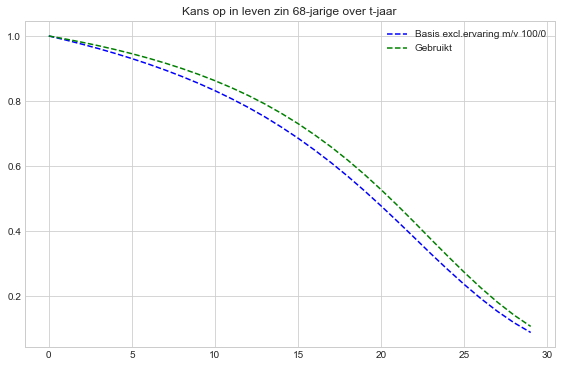

In [19]:
%matplotlib inline
display(slDeelM)
display(slFactS)
display(chErvaring)
display(HBox([slCorrM,slCorrV],style=style))

isErvaringsSterfte=chErvaring.value
corrM=slCorrM.value
corrV=slCorrV.value
factorSterfte=slFactS.value
deelMan=slDeelM.value
Px2,nPx2=ovlSpeedActueleLft(isErvaring=isErvaringsSterfte,corrM=corrM,corrV=corrV, factor=factorSterfte,deelMan=deelMan,aantalJaar=slAantJr.value)  
mPx2,mnPx2=ovlSpeedActueleLft(isErvaring=False,corrM=corrM,corrV=corrV, factor=1.0,deelMan=0.5,aantalJaar=slAantJr.value)  

#%matplotlib widget

xSt=range(30)
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [9.5, 6]
figSt, axSt = plt.subplots()  # Create a figure containing a single axes.
plt.title("Kans op in leven zin 68-jarige over t-jaar") 
axSt.plot(xSt,mnPx2[68,0,:30] , '--b', label='Basis excl.ervaring m/v 100/0')
axSt.plot(xSt,nPx2[68,0,:30] , '--g', label='Gebruikt')
#ax.axis('equal')
leg = axSt.legend();


### <font color='green'>Definitie Beschermingsrendement en Projectierendement:</font>
- Projectierendement    = het rendement (de rente) voor het vaststellen van de hoogte van de uitkering: hoe snel potje leeg eten?
- Beschermingsrendement = het rendement dat gepensioneerde/deelnemer krijgt om de uitkering zekerder te maken

Los van eventuele blootstelling aan overrendement geldt dat bij 100% blootstelling aan beschermingsrendement:
- beschermingsrendement = projectierendement geeft een stabiele uitkering
- beschermingsrendement > projectierendement geeft een stijgende uitkering
- beschermingsrendement < projectierendement geeft een dalende uitkering


#### <font color='green'>Projectierendement:</font>
Bij hogere projectierendementen wordt uitgegaan van meer toekomstig rendement op het potje.
De uitkering kan dan bij aanvang hoger zijn. Maar er ontstaat ook een hogere kans op een daling dit rendement niet gehaald wordt.
Basis is uitgaan van risicovrijerente (RTS).

In [4]:
style = {'description_width': 'initial'}
display(HBox([rP,slVastP,rrP,rslVastP]))
display(HBox([slOpslagP,rslOpslagP]))

#### <font color='green'>Beschermingsrendement:</font>
Het beschermingsrendement is bedoeld om de uitkering (of toekomstige uitkering) zekerder te maken. Bij 100% beschermingsrendement (en geen overrendement) waarbij het beschermingsrendement gelijk is het projectierendement krijgt de gepensioneerde een stabiele uitkering.
Bij hogere beschermingsrendementen krijgt de gepensioneerde een hoger zeker rendement op zijn potje.
Echter als dit rendement niet met concrete beleggingen gerealiseerd wordt, leidt dit tot een lager(hoger) overrendement.
Basis is uitgaan van risicovrije rente (RTS). 

In [5]:
display(HBox([rB,slVastB,rrB,rslVastB]))
display(HBox([slOpslagB,rslOpslagB]))

In de grafiek hieronder worden de effecten van de keuzes voor de invulling van het beschermingsrendement en het projectierendement getoond. Voor een scenario en prognose jaar naar keuze wordt getoond welke rentes (in procenten) er dan voor verschillende looptijden gehanteerd worden (stippellijnen) en hoevel euro er op dat moment nodig is om bij de verschillende looptijden 1 euro te kunnen uitkeren (zonder rekening te houden met overlijdenskansen) (cw doorgetrokken lijnen)

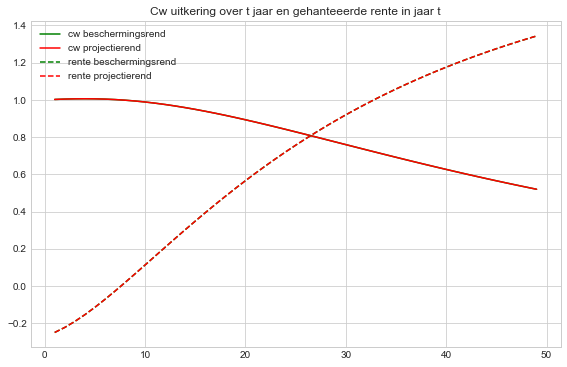

In [6]:
%matplotlib inline
slIndivSc.max=slAantSc.value
slIndivJr.max=slAantJr.value
display(HBox([slIndivSc, slIndivJr],style=style))

style = {'description_width': 'initial'}
opslagBeschermRendement=slOpslagB.value
vastBeschermRendement=slVastB.value
typeBeschermRendement=rB.value
if typeBeschermRendement=="marktrente RTS":
    isBeschermReeel=False
    isVastBeschermRendement=False    
elif typeBeschermRendement=="reele rente":
    isBeschermReeel=True
    isVastBeschermRendement=False      
else:
    isBeschermReeel=False
    isVastBeschermRendement=True
    
opslagProjectieRendement=slOpslagP.value
vastProjectieRendement=slVastP.value
typeProjectieRendement=rP.value
if typeProjectieRendement=="marktrente RTS":
    isProjectieReeel=False
    isVastProjectieRendement=False    
elif typeProjectieRendement=="reele rente":
    isProjectieReeel=True
    isVastProjectieRendement=False      
else:
    isProjectieReeel=False
    isVastProjectieRendement=True

renteB,cwB,renteP,cwP=rentecurvesSpeed(aantalScenarios=slAantSc.value,aantJaren=slAantJr.value,isVastBeschermRendement=isVastBeschermRendement,vastBeschermRendement=vastBeschermRendement,opslagBeschermRendement=opslagBeschermRendement,isBeschermReeel=isBeschermReeel,isVastProjectieRendement=isVastProjectieRendement,vastProjectieRendement=vastProjectieRendement,opslagProjectieRendement=opslagProjectieRendement,isProjectieReeel=isProjectieReeel)      
xR=range(1,50)
cwb=cwB[slIndivSc.value-1,slIndivJr.value-1,1:50]
cwp=cwP[slIndivSc.value-1,slIndivJr.value-1,1:50]
rb=renteB[slIndivSc.value-1,slIndivJr.value-1,1:50]*100
rp=renteP[slIndivSc.value-1,slIndivJr.value-1,1:50]*100

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [9.5, 6]
figR, axR = plt.subplots()  # Create a figure containing a single axes.
plt.title("Cw uitkering over t jaar en gehanteeerde rente in jaar t") 

axR.plot(xR,cwb , '-g', label='cw beschermingsrend')
axR.plot(xR,cwp , '-r', label='cw projectierend')
axR.plot(xR,rb , '--g', label='rente beschermingsrend')
axR.plot(xR,rp , '--r', label='rente projectierend')
#ax.axis('equal')
leg = axR.legend();


### <font color='green'>Verdelingsstaffels beschermingsrendement en overrendement:</font>
- voor beschermingsrendement (X)
- voor overrendement (Y)
Het beschermingsrendement heeft als primair doel uitkeringen zeker stellen
Het overrendement heeft als primair doel "meer" rendement te maken. Dit om later een voldoende hoog pensioenvermogen te bereiken voor een goed pensioen (actieven) of om (voor gepensioneerden) nog rendement te maken na pensioeningang, wat kan zorgen voor een stijging.
Het rendement van de uniforme collectieve beleggingsmix wordt eerst gebruikt om het toegezegde zekerheidsrendement aan deelnemers te geven. Wat daarna overblijft (+ of -) is het overrendement.


Checkbox(value=False, description='kaspositie mee', indent=False)

Checkbox(value=False, description='kaspositie mee ref', indent=False)


Totaal vermogen (mio):  204547  deelBescherming:  40 % deelOverrendement:  69 % samen: 109 %
actief:  80 % gepensioneerd:  19 %




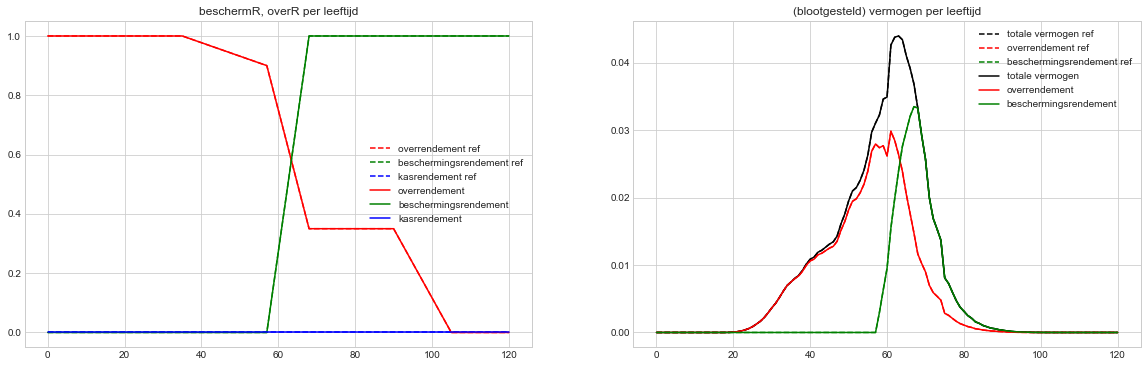

In [7]:
%matplotlib inline
display(HBox([lX0,pX0,lY0,pY0],style=style))
display(HBox([lX1,pX1,lY1,pY1],style=style))
display(HBox([lX2,pX2,lY2,pY2],style=style))
display(HBox([lX3,pX3,lY3,pY3],style=style))
display(HBox([lX4,pX4,lY4,pY4],style=style))
display(HBox([lX5,pX5,lY5,pY5],style=style))
display(HBox([lX6,pX6,lY6,pY6],style=style))
display(chKas)

display(HBox([rlX0,rpX0,rlY0,rpY0],style=style))
display(HBox([rlX1,rpX1,rlY1,rpY1],style=style))
display(HBox([rlX2,rpX2,rlY2,rpY2],style=style))
display(HBox([rlX3,rpX3,rlY3,rpY3],style=style))
display(HBox([rlX4,rpX4,rlY4,rpY4],style=style))
display(HBox([rlX5,rpX5,rlY5,rpY5],style=style))
display(HBox([rlX6,rpX6,rlY6,rpY6],style=style))
display(rchKas)

isKasMee=chKas.value
staffelOver=staffel(lft=[lY0.value,lY1.value,lY2.value,lY3.value,lY4.value,lY5.value,lY6.value],perc=[pY0.value,pY1.value,pY2.value,pY3.value,pY4.value,pY5.value,pY6.value])
staffelBescherm=staffel(lft=[lX0.value,lX1.value,lX2.value,lX3.value,lX4.value,lX5.value,lX6.value],perc=[pX0.value,pX1.value,pX2.value,pX3.value,pX4.value,pX5.value,pX6.value])

risKasMee=rchKas.value
rstaffelOver=staffel(lft=[rlY0.value,rlY1.value,rlY2.value,rlY3.value,rlY4.value,rlY5.value,rlY6.value],perc=[rpY0.value,rpY1.value,rpY2.value,rpY3.value,rpY4.value,rpY5.value,rpY6.value])
rstaffelBescherm=staffel(lft=[rlX0.value,rlX1.value,rlX2.value,rlX3.value,rlX4.value,rlX5.value,rlX6.value],perc=[rpX0.value,rpX1.value,rpX2.value,rpX3.value,rpX4.value,rpX5.value,rpX6.value])

staffelKas=np.zeros(fixGrens)
if isKasMee:
    staffelKas=1.0-staffelOver-staffelBescherm

rstaffelKas=np.zeros(fixGrens)
if risKasMee:
    rstaffelKas=1.0-rstaffelOver-rstaffelBescherm
    
# hier basis voor grafiek staffel
xs=range(fixGrens)
po=staffelOver
pb=staffelBescherm
pk=staffelKas
rpo=rstaffelOver
rpb=rstaffelBescherm
rpk=rstaffelKas

# hier basis voor grafiek portefeuille
pT=np.zeros([fixGrens,slAantSc.value])
pT[:,:]=startColl[:fixGrens]*slDG.value
tV=np.sum(pT[:,0])
deelB=int(np.sum(100*pT[:,0]*staffelBescherm)/tV)
deelO=int(np.sum(100*pT[:,0]*staffelOver)/tV)
rpT=np.zeros([fixGrens,slAantSc.value])
rpT[:,:]=startColl[:fixGrens]*rslDG.value
rtV=np.sum(rpT[:,0])

#vanaf leeftijd pensioen nog niet flexibrel
act=np.zeros(fixGrens)
act[:68]=1.0
gepens=1-act
gep=int(np.sum(100*pT[:,0]*gepens)/tV)
ac=int(np.sum(100*pT[:,0]*act)/tV)

print()
print("Totaal vermogen (mio): ",int(tV/1000000)," deelBescherming: ",deelB,"% deelOverrendement: ", deelO,"% samen:",deelB+deelO,"%")
print("actief: ",ac,"% gepensioneerd: ",gep,"%")
print()
print()

xV=range(fixGrens)
v=pT[:,0]/tV
b=pT[:,0]*staffelBescherm/tV
o=pT[:,0]*staffelOver/tV
rv=rpT[:,0]/tV
rb=rpT[:,0]*rstaffelBescherm/tV
ro=rpT[:,0]*rstaffelOver/tV

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [20, 6]
plt.tight_layout()
plt.subplot(1,2,1)
plt.title("beschermR, overR per leeftijd") 
plt.plot(xs,rpo , '--r', label='overrendement ref')
plt.plot(xs,rpb , '--g', label='beschermingsrendement ref')
plt.plot(xs,rpk , '--b', label='kasrendement ref')
plt.plot(xs,po , '-r', label='overrendement')
plt.plot(xs,pb , '-g', label='beschermingsrendement')
plt.plot(xs,pk , '-b', label='kasrendement')
#ax.axis('equal')
leg = plt.legend();

plt.subplot(1,2,2)
plt.title("(blootgesteld) vermogen per leeftijd") 
#axV.plot(xV, v,'-',b,'g-',o,'r-'); # Plot some data on the axes.
plt.plot(xV,rv , '--k', label='totale vermogen ref')
plt.plot(xV,ro , '--r', label='overrendement ref')
plt.plot(xV,rb , '--g', label='beschermingsrendement ref')
plt.plot(xV,v , '-k', label='totale vermogen')
plt.plot(xV,o , '-r', label='overrendement')
plt.plot(xV,b , '-g', label='beschermingsrendement')
#ax.axis('equal')
leg = plt.legend();


### <font color='green'>Definieer de uitkeringsfase:</font>
De mate van blootstelling aan beschermingsrendement en overrendement zit al in staffels. Dit bepaald de mate van renterisico en rendementrisico dat gepensioneerde nog loopt.
Verder keuzes bij de vormgeving van de uitkeringsfase zijn:
- spreiding: spreiding van schokken over een aantal jaar om effect te dempen
- vaste aanpassing: vaste jaarlijkse stijging of daling van het pensioen: aankoop wordt hierdoor duurder resp. goedkoper. 


Label(value='SPREIDING SCHOKKEN:')

Checkbox(value=False, description='open spreiding', indent=False)

Label(value='SPREIDING SCHOKKEN REF:')

Checkbox(value=False, description='open spreiding ref', indent=False)

Label(value='INGANGSLEEFTIJD EN DALING/STIJGING:')

IntSlider(value=68, description='pensioenleeftijd', max=86, min=65, style=SliderStyle(description_width='initi…

FloatSlider(value=0.0, description='vast aanpassing', max=0.05, min=-0.05, readout_format='7.3p', step=0.005, …

Label(value='INGANGSLEEFTIJD EN DALING/STIJGING REF:')

IntSlider(value=68, description='pensioenleeftijd ref', max=86, min=65, style=SliderStyle(description_width='i…

FloatSlider(value=0.0, description='vast aanpassing ref', max=0.05, min=-0.05, readout_format='7.3p', step=0.0…

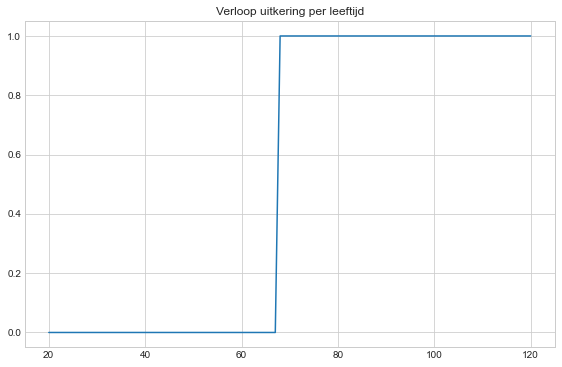

In [8]:
%matplotlib inline
display(widgets.Label(value="SPREIDING SCHOKKEN:"))
display(HBox([lS0,pS0],style=style))
display(HBox([lS1,pS1],style=style))
display(HBox([lS2,pS2],style=style))
display(HBox([lS3,pS3],style=style))
display(chOpenS)
display(HBox([chAfbouwS,slAfbS],style=style))
display(widgets.Label(value="SPREIDING SCHOKKEN REF:"))
display(HBox([rlS0,rpS0],style=style))
display(HBox([rlS1,rpS1],style=style))
display(HBox([rlS2,rpS2],style=style))
display(HBox([rlS3,rpS3],style=style))
display(rchOpenS)
display(HBox([rchAfbouwS,rslAfbS],style=style))

display(widgets.Label(value="INGANGSLEEFTIJD EN DALING/STIJGING:"))
display(slPlft)
display(slAanp)
display(widgets.Label(value="INGANGSLEEFTIJD EN DALING/STIJGING REF:"))
display(rslPlft)
display(rslAanp)

vanafLeeftijd=slPlft.value
totLeeftijd=125
tijdstipUitkering=0 # 0,1,2
aanpassing=slAanp.value
uitk=uitkReeksOP(aanpassing=aanpassing,tijdstipUitkering=tijdstipUitkering,vanafLeeftijd=vanafLeeftijd)

plt.rcParams['figure.figsize'] = [9.5, 6]
plt.style.use('seaborn-whitegrid')
figU, axU = plt.subplots()
plt.title("Verloop uitkering per leeftijd") 
xU=np.arange(20,fixGrens,1)
axU.plot(xU, uitk[0,20:fixGrens], color='C0');

### <font color='green'>Solidariteitsreserve:</font>
De solidariteitsreserve geeft (extra) mogelijkheden voor (intergenerationele) risicodeling. Het is een stukje niet aan de individuele pensioenvermogens toegerekend collectief pensioenvermogen. Een solidariteitsreserve is verplicht binnen NPC en optioneel bij WVP+.
Naast de opties hieronder kan dde solidariteitsreserve ook worden ingezet voor opvang van het macrolanglevenrisico, andere resultaten (resultaat micro langleven, operationele risico's, geen premie wel recht, etc.)

In [9]:
display(widgets.Label(value="SOLIDARITEITSRESERVE:"))
display(chSol)
display(widgets.Label(value="VUL-REGELS:"))
display(HBox([slSolMax,slSolAanvang],style=style))
display(HBox([slSolP,slSolO],style=style))
display(widgets.Label(value="UITDEEL-REGELS:"))
display(HBox([chSolActief,chSolPensioen],style=style))
display(HBox([slSolUitPercRes,slSolUitPercRend,chSolUitMax],style=style))
display(widgets.Label(value="SOLIDARITEITSRESERVE REF:"))
display(rchSol)
display(widgets.Label(value="VUL-REGELS REF:"))
display(HBox([rslSolMax,rslSolAanvang],style=style))
display(HBox([rslSolP,rslSolO],style=style))
display(widgets.Label(value="UITDEEL-REGELS REF:"))
display(HBox([rchSolActief,rchSolPensioen],style=style))
display(HBox([rslSolUitPercRes,rslSolUitPercRend,rchSolUitMax],style=style))


Label(value='SOLIDARITEITSRESERVE:')

Checkbox(value=True, description='solidaritetsreserve mee in sommen', indent=False)

Label(value='VUL-REGELS:')

Label(value='UITDEEL-REGELS:')

Label(value='SOLIDARITEITSRESERVE REF:')

Checkbox(value=True, description='solidaritetsreserve mee in sommen ref', indent=False)

Label(value='VUL-REGELS REF:')

Label(value='UITDEEL-REGELS REF:')

### <font color='green'>Parameters pensioenregeling:</font>
De meest belangrijke parameters voor wat betreft de opbouw in de pensioenregeling zijn het premiepercentage en de franchise.
Voor het totaalinkomen vanaf pensioeningang is de AOW relevant: hier AOW-gehuwd. Het oude opbouw% en de start dekkingsgraad worden gebruikt om voor de doorrekening van deelnemers de startwaarde van hun persoonlijke penioenvermogen te bepalen.

In [10]:
display(widgets.Label(value="SOLIDARITEITSRESERVE:"))
display(slPremie)
display(slFran)
display(slStartOpb)
display(slOpbP)
display(slDG)
display(slAow)
display(widgets.Label(value="SOLIDARITEITSRESERVE REF:"))
display(rslPremie)
display(rslFran)
display(rslStartOpb)
display(rslOpbP)
display(rslDG)
display(rslAow)

Label(value='SOLIDARITEITSRESERVE:')

FloatSlider(value=0.215, description='premiepercentage', max=0.33, readout_format='7.3p', step=0.01, style=Sli…

IntSlider(value=12770, description='franchise', max=20000, step=1000, style=SliderStyle(description_width='ini…

IntSlider(value=26, description='start lft opbouw', max=45, min=15, style=SliderStyle(description_width='initi…

FloatSlider(value=0.0175, description='oude opbouw%', max=0.01875, readout_format='7.4p', step=0.001, style=Sl…

FloatSlider(value=1.0, description='start DG', max=1.5, min=0.8, step=0.01, style=SliderStyle(description_widt…

IntSlider(value=10900, description='AOW', max=20000, step=100, style=SliderStyle(description_width='initial'))

Label(value='SOLIDARITEITSRESERVE REF:')

FloatSlider(value=0.215, description='premiepercentage ref', max=0.33, readout_format='7.3p', step=0.01, style…

IntSlider(value=12770, description='franchise ref', max=20000, step=1000, style=SliderStyle(description_width=…

IntSlider(value=26, description='start lft opbouw ref', max=45, min=15, style=SliderStyle(description_width='i…

FloatSlider(value=0.0175, description='oude opbouw% ref', max=0.01875, readout_format='7.4p', step=0.001, styl…

FloatSlider(value=1.0, description='start DG ref', max=1.5, min=0.8, step=0.01, style=SliderStyle(description_…

IntSlider(value=10900, description='AOW ref', max=20000, step=100, style=SliderStyle(description_width='initia…

### <font color='green'>Parameters deelnemer:</font>
Gegevens van de door te rekenen deelnemers

In [11]:
display(HBox([slSal, chEindSal,slProm,slOpslagLoon],style=style))
display(HBox([slDtf,chSlaper,chEenJaarPremie],style=style))
display(HBox([slSaldo, chSaldoRecht,slRecht,chMLRecht],style=style))
display(slAchterstand)

FloatSlider(value=0.0, description='indexatieachterstand', max=0.3, readout_format='7.3p', step=0.01, style=Sl…

### <font color='blue'>Doorloop alle prognosejaren:</font>
Dit kost even tijd........ :)

In [12]:
indivScenario=slIndivSc.value
indivJaar=1
minLft=20
maxLft=120

aantalScenarios=slAantSc.value
aantalJaar=slAantJr.value

startDG=rslDG.value

vanafLeeftijd=rslPlft.value
totLeeftijd=125
tijdstipUitkering=0 # 0,1,2
aanpassing=rslAanp.value

isErvaringsSterfte=rchErvaring.value
corrM=0
corrV=0
factorSterfte=rslFactS.value
deelMan=rslDeelM.value
Px2,nPx2=ovlSpeedActueleLft(isErvaring=isErvaringsSterfte,corrM=corrM,corrV=corrV, factor=factorSterfte,deelMan=deelMan,aantalJaar=aantalJaar)  

opslagBeschermRendement=rslOpslagB.value
vastBeschermRendement=rslVastB.value
typeBeschermRendement=rrB.value
if typeBeschermRendement=="marktrente RTS":
    isBeschermReeel=False
    isVastBeschermRendement=False    
elif typeBeschermRendement=="reele rente":
    isBeschermReeel=True
    isVastBeschermRendement=False      
else:
    isBeschermReeel=False
    isVastBeschermRendement=True
opslagBeschermRendement=rslOpslagB.value
vastBeschermRendement=rslVastB.value
typeBeschermRendement=rrB.value
if typeBeschermRendement=="marktrente RTS":
    isBeschermReeel=False
    isVastBeschermRendement=False    
elif typeBeschermRendement=="reele rente":
    isBeschermReeel=True
    isVastBeschermRendement=False      
else:
    isBeschermReeel=False
    isVastBeschermRendement=True
renteB,cwB,renteP,cwP=rentecurvesSpeed(aantalScenarios=aantalScenarios,aantJaren=aantalJaar,isVastBeschermRendement=isVastBeschermRendement,vastBeschermRendement=vastBeschermRendement,opslagBeschermRendement=opslagBeschermRendement,isBeschermReeel=isBeschermReeel,isVastProjectieRendement=isVastProjectieRendement,vastProjectieRendement=vastProjectieRendement,opslagProjectieRendement=opslagProjectieRendement,isProjectieReeel=isProjectieReeel)   

isOpenSpreiding=rchOpenS.value
duurSpreiding=1
isAfbouwSpreiding=rchAfbouwS.value
lftAfbouwSpreiding=rslAfbS.value
staffelSpreiding=staffelDuurSpreiding(lft=[rlS0.value,rlS1.value,rlS2.value,rlS3.value],duur=[rpS0.value,rpS1.value,rpS2.value,rpS3.value],isAfbouwSpreiding=isAfbouwSpreiding,lftAfbouwSpreiding=lftAfbouwSpreiding) 

isKasMee=rchKas.value
staffelOver=staffel(lft=[rlY0.value,rlY1.value,rlY2.value,rlY3.value,rlY4.value,rlY5.value,rlY6.value],perc=[rpY0.value,rpY1.value,rpY2.value,rpY3.value,rpY4.value,rpY5.value,rpY6.value])
staffelBescherm=staffel(lft=[rlX0.value,rlX1.value,rlX2.value,rlX3.value,rlX4.value,rlX5.value,rlX6.value],perc=[rpX0.value,rpX1.value,rpX2.value,rpX3.value,rpX4.value,rpX5.value,rpX6.value])
staffelKas=np.zeros(fixGrens)
if isKasMee:
    staffelKas=1.0-staffelOver-staffelBescherm

solMax=rslSolMax.value
solAanvang=rslSolAanvang.value
afslagPremie=rslSolP.value
afslagRendement=rslSolO.value
isSolRes=rchSol.value
if isSolRes==False:
    afslagPremie=0.0
    solAanvang=0.0
    afslagRendement=0.0
uitdeelActief=rchSolActief.value
uitdeelGepensioneerd=rchSolPensioen.value
uitdeelPercRes=rslSolUitPercRes.value
uitdeelPercOnder=rslSolUitPercRend.value
uitdeelMaxOnder=rchSolUitMax.value
    
premiePercentage=rslPremie.value
opbouwPerc=rslOpbP.value
startFranchise=rslFran.value
startLftOpbouw=rslStartOpb.value
startDG=rslDG.value
startAOW=rslAow.value

#niet anders
startSaldo=slSaldo.value
startSalaris=slSal.value
isEindSal=chEindSal.value
factorPromotie=slProm.value
opslagLoonInfl=slOpslagLoon.value
deeltijdFactor=slDtf.value
startRecht=slRecht.value
isSlaper=chSlaper.value
achterstand=slAchterstand.value
eenJaarPremie=chEenJaarPremie.value

act=np.zeros(fixGrens)
act[:vanafLeeftijd]=1.0
gepens=1-act
# opbouw basisregeling incl allen
actiefC=act.copy()[:,np.newaxis]
# opbouw deelnemer alleen cf opbouw
act[:startLftOpbouw]=0.0
actief=act[:,np.newaxis]
gepensioneerd=gepens[:,np.newaxis]   

uitk=uitkReeksOP(aanpassing=aanpassing,tijdstipUitkering=tijdstipUitkering,vanafLeeftijd=vanafLeeftijd)
uitkLat=uitkReeksOPLat(aanpassing=aanpassing,tijdstipUitkering=tijdstipUitkering,vanafLeeftijd=vanafLeeftijd,duurSpreiden=staffelSpreiding)


#uitkLat[]

#deelnemers bijhouden resultaten over alle jaren. Basis is steeds startleeftijd deelnemers!! primostanden
aow=np.zeros([aantalJaar+1,fixGrens,aantalScenarios]) #langer dan nodig 1 dim 
aow[0,:,:]=startAOW
promotieFact=promotie(lftTM=[35,45,55],perc=[0.03,0.02,0.01],weging=factorPromotie)
if isEindSal:
        startSalaris=startSalaris/np.cumprod(promotieFact)[-1]
promotieFact[:startLftOpbouw]=1.0
pf=np.roll(promotieFact,1)
s=startSalaris*np.cumprod(pf).transpose()
#nog kijken wat passend is voor slaper en dtf=0
gsD=np.maximum(s-startFranchise,0)*deeltijdFactor
startGS=np.zeros(fixGrens)
somGS=0
aant=0
for lf in range(startLftOpbouw,vanafLeeftijd):
    somGS=somGS+gsD[lf]
    aant=aant+1
    startGS[lf]=somGS/aant
startGS[vanafLeeftijd:]=startGS[vanafLeeftijd-1]

salaris=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
salaris[0,:,:]=s[:,np.newaxis]
kk=np.ones([aantalJaar+1,fixGrens,aantalScenarios])
recht=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
potjes=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
gsD=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
gsD[0,:,:]=startGS[:,np.newaxis]

#collectief
potInJaarT=np.zeros([fixGrens,aantalScenarios])
potInJaarT[:,:]=startColl[:fixGrens]*startDG
totaalV=np.sum(potInJaarT[:,0])
gs=np.zeros([fixGrens+136,81])
gs[:136,:]=startTotGS
solidariteitsRes=np.zeros(aantalScenarios)
solidariteitsRes[:]=solAanvang*totaalV*isSolRes
rendementen=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenNaInSol=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenNaUitSol=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenSolVPV=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenInSolPremie=np.zeros([aantalJaar,fixGrens,aantalScenarios])
omvangSolRes=np.zeros([aantalJaar+1,aantalScenarios])
omvangSolRes[0,:]=solAanvang

jr=0		

#bereken gem middelloon GS

base=nPx2[:,jr,jr:]*uitk[:,jr:]
cwPrimo=np.sum(base*cwB[:,jr,np.newaxis,:126-jr],axis=2)
if chSaldoRecht.value:
    if chMLRecht.value:
        mlR=np.zeros(fixGrens)
        for lf in range(startLftOpbouw,fixGrens-1):
            mlR[lf+1]=mlR[lf]+act[lf]*opbouwPerc*deeltijdFactor*(salaris[0,lf,0]-startFranchise)
        recht=np.ones([aantalJaar+1,fixGrens,aantalScenarios])
        #indexatieachterstand grof (voor jongere minder), startDG grof, voor hele oude minder dan x% korting
        recht[jr,:,:]=recht[jr,:,:]*mlR[:,np.newaxis]*startDG*(1-achterstand)
        recht[jr+1:,:,:]=0.0
    else:
        recht[jr,:,:]=startRecht
    potjes[jr,:,:]=recht[jr,:,:]*cwPrimo.transpose()    
else:
    potjes[jr,:,:]=startSaldo
    recht[jr,:,:]=potjes[jr,:,:]/(cwPrimo.transpose())
rechtInJaarT=potInJaarT/cwPrimo.transpose()

#voor doorrekenen per actuele leeftijd waarde voor alle scenarios
salInJaar=salaris[0,:,:].copy()
franInJaar=startFranchise
kkInJaar=kk[0,:,:].copy()
aowInJaar=aow[0,:,:].copy()
gsInJaar=gsD[0,:,:].copy()

uitkDInJaar=np.zeros([aantalScenarios,fixGrens,126])
r=recht[0,:,0]
r=uitk*(r[:,np.newaxis])
uitkDInJaar[:,:,:]=uitkDInJaar[:,:,:]+r[np.newaxis,:,:]

potInJaar=potjes[0,:,:].copy()
rechtInJaar=recht[0,:,:].copy()
uitSolInJaar=np.zeros([fixGrens,aantalScenarios])
uitSolInJaarVPV=np.zeros([fixGrens,aantalScenarios])
inSolPremieJaar=np.zeros([fixGrens,aantalScenarios])
omvangSolResInJaar=np.zeros(aantalScenarios)

                            

#print(salInJaar[:,0],"  ",potInJaar[:,0]," ",rechtInJaar[:,0])

if isSlaper:
    deeltijdFactor=0.0


if chRecalc.value:


    for jr in range(0,aantalJaar):
     
        #print("lft ",68+jr," ",uitkDInJaar[0, 68+jr,:11])
        #print("primo: ",potInJaar[min(fixGrens-2,68+jr),0],"  ",rechtInJaar[min(fixGrens-2,68+jr),0])
 
        # 1. premie-inleg
        fp=1.0
        if eenJaarPremie and jr>0:
            fp=0.0
        premie=(fp*deeltijdFactor*premiePercentage*(salInJaar-franInJaar))*actief
        premieT=gs[64-jr:64-jr+fixGrens ,jr,np.newaxis]/kkInJaar*premiePercentage*actiefC
        potInJaar=potInJaar+premie*(1-afslagPremie)
        potInJaarT=potInJaarT+premieT*(1-afslagPremie)
        solidariteitsRes=solidariteitsRes+np.sum(premieT,axis=0)*afslagPremie
        
        # 2.  uitkering
        betalingUitkering=rechtInJaar*gepensioneerd
        betalingUitkeringT=rechtInJaarT*gepensioneerd
        potInJaar=potInJaar-betalingUitkering
        potInJaarT=potInJaarT-betalingUitkeringT
        #print("na p en u: ",potInJaar[68+jr,0])
     
        # 3. ongecorrigeerd rendement
        #base=nPx2[:,jr,:]*uitk
        base=nPx2[:,jr,:]*uitkDInJaar
        base=base[:,:,1:]
        oudeR=cwB[:,jr,1:]
        cwOud=np.nan_to_num(np.sum(base*oudeR[:,np.newaxis,:],axis=2))
        nweR=cwB[:,jr+1,:126-1]
        cwNw=np.sum(base*nweR[:,np.newaxis,:],axis=2) 
        beschermR=np.divide(cwNw,cwOud,out=np.ones_like(cwNw), where=cwOud!=0)-1.0
        beschermR=beschermR[:,:]
        kasR=renteB[:,jr,1]
        rend=np.nan_to_num(beschermR*staffelBescherm+(aandelenRend[:,jr]*staffelOver[:,np.newaxis]).transpose())
        rendExclKas=rend.copy()
        rend=rend+staffelKas.transpose()*kasR[:,np.newaxis]
        rendZuiver=rend.copy()
        
        potVoorIndex=potInJaar.copy()
        potVoorIndexT=potInJaarT.copy()
        
        #print(beschermR[0,68+jr]," ",aandelenRend[0,jr]," ",renteB[0,jr,1]," ",rend[0,68+jr])
        
        # 4. totaalrendement na vatstellen overrendement rekening met vullen solreseserve 
        if isSolRes:
            potVoor=np.sum(potInJaarT,axis=0)        
            potNa=np.sum(potInJaarT*(1.0+rendExclKas.transpose()),axis=0)
            totaalRendement=potNa-potVoor
            rendementT=totaalRendement/potVoor

            totaalBescherm=np.sum(potInJaarT*(beschermR*staffelBescherm).transpose(),axis=0)
            totaalOver=totaalRendement-totaalBescherm        
            afslagVoorRes=np.maximum(totaalOver,0.0)*afslagRendement            
            totaalOver=totaalOver-afslagVoorRes
            grondslagOver=np.sum(potInJaarT*staffelOver[:,np.newaxis],axis=0)
            overrendementsPerc=totaalOver/grondslagOver 
            
            solidariteitsRes=solidariteitsRes*(rendementT+1.0)            
            solidariteitsRes=solidariteitsRes+afslagVoorRes     

            #gecorrigeerd rend
            rend=np.nan_to_num(beschermR*staffelBescherm+(overrendementsPerc*staffelOver[:,np.newaxis]).transpose())
            rend=rend+staffelKas.transpose()*kasR[:,np.newaxis]
        
        potInJaar=potInJaar*(1+rend.transpose())
        potInJaarT=potInJaarT*(1+rend.transpose())
        #print("na rend ",potInJaar[68+jr,0])
        
        # 5 risicoPremies/biometrischrendement
        tr=np.divide((1-Px2[:,jr]),Px2[:,jr],out=np.zeros_like((1-Px2[:,jr])), where=Px2[:,jr]!=0)
        risP=potInJaar*tr[:,np.newaxis] 
        potInJaar=potInJaar+risP        
        #print("na risP: ",potInJaar[68+jr,0])
        
        # 6. Uitdelen solidariteitsreserve
        pSUitd=np.zeros(aantalScenarios)
        potInJaarVoorUitdeelT=potInJaarT.copy()
        
        if isSolRes:
            inSolPremieJaar=np.divide(premieT*afslagPremie,potVoorIndexT,out=np.zeros_like(premieT), where=potVoorIndexT!=0)
 
            if uitdeelPercRes>0.0:
                # voor gemak optelbaarheid uitdelen obv stand na P en U voor index
                uitdeelGroep=gepensioneerd*uitdeelGepensioneerd+actiefC*uitdeelActief                
                uitdelen=solidariteitsRes*uitdeelPercRes
                solidariteitsRes-uitdelen
                extra=np.maximum(solidariteitsRes-solMax*np.sum(potInJaarT,axis=0),0.0)
                uitdelen=uitdelen+extra
                solidariteitsRes=solidariteitsRes-extra
                pSUitd=uitdelen/np.sum(uitdeelGroep*potVoorIndexT,axis=0)
                potInJaarT=potInJaarT+uitdeelGroep*potVoorIndexT*pSUitd
                potInJaar=potInJaar+uitdeelGroep*potVoorIndex*pSUitd
                uitSolInJaarVPV=np.divide(potInJaarT-potInJaarVoorUitdeelT,potVoorIndexT,out=np.zeros_like(potInJaarT), where=potVoorIndexT!=0)
            else:
                deel=uitdeelPercOnder
                if uitdeelMaxOnder:
                    deel=1.0
                uitdeelGroep=gepensioneerd*uitdeelGepensioneerd+actiefC*uitdeelActief  
                gsUitdelen=uitdeelGroep*potVoorIndexT*staffelOver[:,np.newaxis]
                gsUitdelenT=np.sum(gsUitdelen,axis=0)                   
                uitdelenT=-deel*np.minimum(overrendementsPerc,0.0)*gsUitdelenT                
                uitdelenT=np.minimum(uitdelenT,solidariteitsRes)                
                uitdelenT=uitdelenT+np.maximum(solidariteitsRes-uitdelenT-solMax*np.sum(potInJaarT,axis=0),0.0)                
                solidariteitsRes=solidariteitsRes-uitdelenT                                  
                pSUitd=np.divide(uitdelenT,gsUitdelenT,out=np.zeros_like(uitdelenT), where=gsUitdelenT!=0)                                
                potInJaarT=potInJaarT+uitdeelGroep*potVoorIndexT*staffelOver[:,np.newaxis]*pSUitd
                potInJaar=potInJaar+uitdeelGroep*potVoorIndex*staffelOver[:,np.newaxis]*pSUitd    
                #print((uitdeelGroep*potVoorIndexT*staffelOver[:,np.newaxis]*pSUitd/potVoorIndexT)[60:78,1:5])
                uitSolInJaar=np.divide(potInJaarT-potInJaarVoorUitdeelT,potVoorIndexT,out=np.zeros_like(potInJaarT), where=potVoorIndexT!=0)
        
        # 7. nieuwe recht:  later nog geavanceerd met spreiden
        
        #basis cw ultimo
        base=nPx2[1:,jr+1,:]*uitk[:fixGrens-1,:]
        cwUltimo=np.sum(base*cwB[:,jr+1,np.newaxis,:],axis=2).transpose()
        
        #naar reeks toekomst schuif alle uitkringen 1 op eerste weg    
        uitkDInJaar=np.roll(uitkDInJaar,-1,axis=2)
        baseNodig=nPx2[np.newaxis,1:,jr+1,:126-1]*uitkDInJaar[:,:fixGrens-1,:126-1]        
        cwNodig=np.sum(baseNodig*cwB[:,jr+1,np.newaxis,:126-1],axis=2).transpose()
        delta=potInJaar[:fixGrens-1,:]-cwNodig
        #print(" nodig en delta ",cwNodig[68+jr,0]," ",delta[68+jr,0])
        if isOpenSpreiding:
            perc=np.divide(delta,cwNodig,out=np.zeros_like(delta), where=cwNodig!=0)
            perc=perc/staffelSpreiding[:fixGrens-1,np.newaxis]
            uitkDInJaar[:,:fixGrens-1,:]=uitkDInJaar[:,:fixGrens-1,:]*(1+perc[np.newaxis,:,:]).transpose()                   
        else:
            baseSpreid=nPx2[1:,jr+1,:]*uitkLat[:fixGrens-1,:]
            cwUltimoSpreid=np.sum(baseSpreid*cwB[:,jr+1,np.newaxis,:],axis=2).transpose()
            stap=np.divide(delta,cwUltimoSpreid,out=np.zeros_like(delta), where=cwUltimoSpreid!=0)
            wijziging=stap.transpose()[:,:fixGrens-1,np.newaxis]*uitkLat[np.newaxis,:fixGrens-1,:]
            uitkDInJaar[:,:fixGrens-1,:]=uitkDInJaar[:,:fixGrens-1,:]+wijziging
        
        rechtInJaar[:fixGrens-1,:]=uitkDInJaar[:,:fixGrens-1,0].transpose()
        rechtInJaarT[:fixGrens-1]=np.divide(potInJaarT[:fixGrens-1],cwUltimo,out=np.zeros_like(potInJaarT[:fixGrens-1]), where=cwUltimo!=0)        
        #print("vermogen",np.sum(potInJaarT[:,0])/1000000000,"rend ",rendementT[0]*100,"% solRes ",solidariteitsRes[0]/1000000000,"uitd ",pSUitd[0]*100,"premie",np.sum(premieT[:,0])/1000000000," uitbet",np.sum(betalingUitkeringT[:,0])/1000000000)
        
        
        # 8a. update naar nwe jaar inflatie, S,f, en doorschuiven next lft
        fact=inflatie[:,jr]+1.0
        kkInJaar=kkInJaar/fact
        franInJaar=franInJaar*fact
        aowInJaar=aowInJaar*fact
        gsInJaar=gsInJaar*fact
        # vraag is wat je met F en AOW doet als je in bouwfase looninflatie volgt (en of opgoging gs toch complexer moet dan: gedifferentieert naar lft< en >= plft)
        salInJaar=salInJaar*(fact+opslagLoonInfl)*promotieFact[:,np.newaxis]
        
        # 8b. vasthouden resultaten per prognose jaar, is nieuw primo stand voor jaar+1, verschuif naar startlft
        if jr<=aantalJaar:
            kk[jr+1,:fixGrens-jr,:]=kkInJaar[jr:,:]
            aow[jr+1,:fixGrens-jr,:]=aowInJaar[jr:,:]        
            salaris[jr+1,:fixGrens-jr,:]=salInJaar[jr:,:]        
            potjes[jr+1,:fixGrens-jr,:]=potInJaar[jr:,:]
            recht[jr+1,:fixGrens-jr,:]=rechtInJaar[jr:,:]
            gsD[jr+1,:fixGrens-jr,:]=gsInJaar[jr:,:]     
            
            # onverschoven totaal
            rendementen[jr,:,:]=rendZuiver[:,:].transpose()
            rendementenNaInSol[jr,:,:]=rend[:,:].transpose()
            rendementenNaUitSol[jr,:,:]=uitSolInJaar[:,:]
            rendementenSolVPV[jr,:,:]=uitSolInJaarVPV[:,:]
            rendementenInSolPremie[jr,:,:]=inSolPremieJaar[:,:]
            omvangSolRes[jr+1,:]=np.divide(solidariteitsRes,np.sum(potInJaarT,axis=0),out=np.zeros_like(solidariteitsRes), where=np.sum(potInJaarT,axis=0)!=0)
            
        # 8c. doorschuiven volgende jaar
        potInJaar=np.roll(potInJaar,1,axis=0)
        potInJaar[0,:]=0
        rechtInJaar=np.roll(rechtInJaar,1,axis=0)
        rechtInJaar[0,:]=0
        potInJaarT=np.roll(potInJaarT,1,axis=0)
        potInJaarT[0,:]=0
        rechtInJaarT=np.roll(rechtInJaarT,1,axis=0)
        rechtInJaarT[0,:]=0
        uitkDInJaar=np.roll(uitkDInJaar,1,axis=1)
        uitkDInJaar[:,0,:]=0

rkk=kk.copy()
raow=aow.copy()
rsalaris=salaris.copy()           
rpotjes=potjes.copy()
rrecht=recht.copy()
rgsD=gsD.copy()       
rrendementen=rendementen.copy()
rrendementenNaInSol=rendementenNaInSol.copy()
rrendementenNaUitSol=rendementenNaUitSol.copy()
rrendementenSolVPV=rendementenSolVPV.copy()
rrendementenInSolPremie=rendementenInSolPremie.copy()
romvangSolRes=omvangSolRes.copy()
rnPx2=nPx2.copy()
        
        

In [13]:
indivScenario=slIndivSc.value
indivJaar=1
minLft=20
maxLft=120

aantalScenarios=slAantSc.value
aantalJaar=slAantJr.value
startDG=slDG.value

vanafLeeftijd=slPlft.value
totLeeftijd=125
tijdstipUitkering=0 # 0,1,2
aanpassing=slAanp.value


isErvaringsSterfte=chErvaring.value
corrM=0
corrV=0
factorSterfte=slFactS.value
deelMan=slDeelM.value
Px2,nPx2=ovlSpeedActueleLft(isErvaring=isErvaringsSterfte,corrM=corrM,corrV=corrV, factor=factorSterfte,deelMan=deelMan,aantalJaar=aantalJaar)  

opslagBeschermRendement=slOpslagB.value
vastBeschermRendement=slVastB.value
typeBeschermRendement=rB.value
if typeBeschermRendement=="marktrente RTS":
    isBeschermReeel=False
    isVastBeschermRendement=False    
elif typeBeschermRendement=="reele rente":
    isBeschermReeel=True
    isVastBeschermRendement=False      
else:
    isBeschermReeel=False
    isVastBeschermRendement=True
opslagBeschermRendement=slOpslagB.value
vastBeschermRendement=slVastB.value
typeBeschermRendement=rB.value
if typeBeschermRendement=="marktrente RTS":
    isBeschermReeel=False
    isVastBeschermRendement=False    
elif typeBeschermRendement=="reele rente":
    isBeschermReeel=True
    isVastBeschermRendement=False      
else:
    isBeschermReeel=False
    isVastBeschermRendement=True
renteB,cwB,renteP,cwP=rentecurvesSpeed(aantalScenarios=aantalScenarios,aantJaren=aantalJaar,isVastBeschermRendement=isVastBeschermRendement,vastBeschermRendement=vastBeschermRendement,opslagBeschermRendement=opslagBeschermRendement,isBeschermReeel=isBeschermReeel,isVastProjectieRendement=isVastProjectieRendement,vastProjectieRendement=vastProjectieRendement,opslagProjectieRendement=opslagProjectieRendement,isProjectieReeel=isProjectieReeel)   

isOpenSpreiding=chOpenS.value
duurSpreiding=1
isAfbouwSpreiding=chAfbouwS.value
lftAfbouwSpreiding=slAfbS.value
staffelSpreiding=staffelDuurSpreiding(lft=[lS0.value,lS1.value,lS2.value,lS3.value],duur=[pS0.value,pS1.value,pS2.value,pS3.value],isAfbouwSpreiding=isAfbouwSpreiding,lftAfbouwSpreiding=lftAfbouwSpreiding) 

isKasMee=chKas.value
staffelOver=staffel(lft=[lY0.value,lY1.value,lY2.value,lY3.value,lY4.value,lY5.value,lY6.value],perc=[pY0.value,pY1.value,pY2.value,pY3.value,pY4.value,pY5.value,pY6.value])
staffelBescherm=staffel(lft=[lX0.value,lX1.value,lX2.value,lX3.value,lX4.value,lX5.value,lX6.value],perc=[pX0.value,pX1.value,pX2.value,pX3.value,pX4.value,pX5.value,pX6.value])
staffelKas=np.zeros(fixGrens)
if isKasMee:
    staffelKas=1.0-staffelOver-staffelBescherm

solMax=slSolMax.value
solAanvang=slSolAanvang.value
afslagPremie=slSolP.value
afslagRendement=slSolO.value
isSolRes=chSol.value
if isSolRes==False:
    afslagPremie=0.0
    solAanvang=0.0
    afslagRendement=0.0
uitdeelActief=chSolActief.value
uitdeelGepensioneerd=chSolPensioen.value
uitdeelPercRes=slSolUitPercRes.value
uitdeelPercOnder=slSolUitPercRend.value
uitdeelMaxOnder=chSolUitMax.value
    
premiePercentage=slPremie.value
opbouwPerc=slOpbP.value
startFranchise=slFran.value
startLftOpbouw=slStartOpb.value
startDG=slDG.value
startAOW=slAow.value

startSaldo=slSaldo.value
startSalaris=slSal.value
isEindSal=chEindSal.value
factorPromotie=slProm.value
opslagLoonInfl=slOpslagLoon.value
deeltijdFactor=slDtf.value
startRecht=slRecht.value
isSlaper=chSlaper.value
achterstand=slAchterstand.value
eenJaarPremie=chEenJaarPremie.value

act=np.zeros(fixGrens)
act[:vanafLeeftijd]=1.0
gepens=1-act
# opbouw basisregeling incl allen
actiefC=act.copy()[:,np.newaxis]
# opbouw deelnemer alleen cf opbouw
act[:startLftOpbouw]=0.0
actief=act[:,np.newaxis]
gepensioneerd=gepens[:,np.newaxis]   

uitk=uitkReeksOP(aanpassing=aanpassing,tijdstipUitkering=tijdstipUitkering,vanafLeeftijd=vanafLeeftijd)
uitkLat=uitkReeksOPLat(aanpassing=aanpassing,tijdstipUitkering=tijdstipUitkering,vanafLeeftijd=vanafLeeftijd,duurSpreiden=staffelSpreiding)


#uitkLat[]

#deelnemers bijhouden resultaten over alle jaren. Basis is steeds startleeftijd deelnemers!! primostanden
aow=np.zeros([aantalJaar+1,fixGrens,aantalScenarios]) #langer dan nodig 1 dim 
aow[0,:,:]=startAOW
promotieFact=promotie(lftTM=[35,45,55],perc=[0.03,0.02,0.01],weging=factorPromotie)
if isEindSal:
        startSalaris=startSalaris/np.cumprod(promotieFact)[-1]
promotieFact[:startLftOpbouw]=1.0
pf=np.roll(promotieFact,1)
s=startSalaris*np.cumprod(pf).transpose()
#nog kijken wat passend is voor slaper en dtf=0
gsD=np.maximum(s-startFranchise,0)*deeltijdFactor
startGS=np.zeros(fixGrens)
somGS=0
aant=0
for lf in range(startLftOpbouw,vanafLeeftijd):
    somGS=somGS+gsD[lf]
    aant=aant+1
    startGS[lf]=somGS/aant
startGS[vanafLeeftijd:]=startGS[vanafLeeftijd-1]

salaris=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
salaris[0,:,:]=s[:,np.newaxis]
kk=np.ones([aantalJaar+1,fixGrens,aantalScenarios])
recht=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
potjes=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
gsD=np.zeros([aantalJaar+1,fixGrens,aantalScenarios])
gsD[0,:,:]=startGS[:,np.newaxis]

#collectief
potInJaarT=np.zeros([fixGrens,aantalScenarios])
potInJaarT[:,:]=startColl[:fixGrens]*startDG
totaalV=np.sum(potInJaarT[:,0])
gs=np.zeros([fixGrens+136,81])
gs[:136,:]=startTotGS
solidariteitsRes=np.zeros(aantalScenarios)
solidariteitsRes[:]=solAanvang*totaalV*isSolRes
rendementen=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenNaInSol=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenNaUitSol=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenSolVPV=np.zeros([aantalJaar,fixGrens,aantalScenarios])
rendementenInSolPremie=np.zeros([aantalJaar,fixGrens,aantalScenarios])
omvangSolRes=np.zeros([aantalJaar+1,aantalScenarios])
omvangSolRes[0,:]=solAanvang

jr=0		

#bereken gem middelloon GS

base=nPx2[:,jr,jr:]*uitk[:,jr:]
cwPrimo=np.sum(base*cwB[:,jr,np.newaxis,:126-jr],axis=2)
if chSaldoRecht.value:
    if chMLRecht.value:
        mlR=np.zeros(fixGrens)
        for lf in range(startLftOpbouw,fixGrens-1):
            mlR[lf+1]=mlR[lf]+act[lf]*opbouwPerc*deeltijdFactor*(salaris[0,lf,0]-startFranchise)
        recht=np.ones([aantalJaar+1,fixGrens,aantalScenarios])
        #indexatieachterstand grof (voor jongere minder), startDG grof, voor hele oude minder dan x% korting
        recht[jr,:,:]=recht[jr,:,:]*mlR[:,np.newaxis]*startDG*(1-achterstand)
        recht[jr+1:,:,:]=0.0
    else:
        recht[jr,:,:]=startRecht
    potjes[jr,:,:]=recht[jr,:,:]*cwPrimo.transpose()    
else:
    potjes[jr,:,:]=startSaldo
    recht[jr,:,:]=potjes[jr,:,:]/(cwPrimo.transpose())
rechtInJaarT=potInJaarT/cwPrimo.transpose()

#voor doorrekenen per actuele leeftijd waarde voor alle scenarios
salInJaar=salaris[0,:,:].copy()
franInJaar=startFranchise
kkInJaar=kk[0,:,:].copy()
aowInJaar=aow[0,:,:].copy()
gsInJaar=gsD[0,:,:].copy()

uitkDInJaar=np.zeros([aantalScenarios,fixGrens,126])
r=recht[0,:,0]
r=uitk*(r[:,np.newaxis])
uitkDInJaar[:,:,:]=uitkDInJaar[:,:,:]+r[np.newaxis,:,:]

potInJaar=potjes[0,:,:].copy()
rechtInJaar=recht[0,:,:].copy()
uitSolInJaar=np.zeros([fixGrens,aantalScenarios])
uitSolInJaarVPV=np.zeros([fixGrens,aantalScenarios])
inSolPremieJaar=np.zeros([fixGrens,aantalScenarios])
omvangSolResInJaar=np.zeros(aantalScenarios)

                            

#print(salInJaar[:,0],"  ",potInJaar[:,0]," ",rechtInJaar[:,0])

if isSlaper:
    deeltijdFactor=0.0


if chRecalc.value:

    for jr in range(0,aantalJaar):

        
        #print("lft ",68+jr," ",uitkDInJaar[0, 68+jr,:11])
        #print("primo: ",potInJaar[min(fixGrens-2,68+jr),0],"  ",rechtInJaar[min(fixGrens-2,68+jr),0])
 
        # 1. premie-inleg
        fp=1.0
        if eenJaarPremie and jr>0:
            fp=0.0
        premie=(fp*deeltijdFactor*premiePercentage*(salInJaar-franInJaar))*actief
        premieT=gs[64-jr:64-jr+fixGrens ,jr,np.newaxis]/kkInJaar*premiePercentage*actiefC
        potInJaar=potInJaar+premie*(1-afslagPremie)
        potInJaarT=potInJaarT+premieT*(1-afslagPremie)
        solidariteitsRes=solidariteitsRes+np.sum(premieT,axis=0)*afslagPremie
        
        # 2.  uitkering
        betalingUitkering=rechtInJaar*gepensioneerd
        betalingUitkeringT=rechtInJaarT*gepensioneerd
        potInJaar=potInJaar-betalingUitkering
        potInJaarT=potInJaarT-betalingUitkeringT
        #print("na p en u: ",potInJaar[68+jr,0])
     
        # 3. ongecorrigeerd rendement
        #base=nPx2[:,jr,:]*uitk
        base=nPx2[:,jr,:]*uitkDInJaar
        base=base[:,:,1:]
        oudeR=cwB[:,jr,1:]
        cwOud=np.nan_to_num(np.sum(base*oudeR[:,np.newaxis,:],axis=2))
        nweR=cwB[:,jr+1,:126-1]
        cwNw=np.sum(base*nweR[:,np.newaxis,:],axis=2) 
        beschermR=np.divide(cwNw,cwOud,out=np.ones_like(cwNw), where=cwOud!=0)-1.0
        beschermR=beschermR[:,:]
        kasR=renteB[:,jr,1]
        rend=np.nan_to_num(beschermR*staffelBescherm+(aandelenRend[:,jr]*staffelOver[:,np.newaxis]).transpose())
        rendExclKas=rend.copy()
        rend=rend+staffelKas.transpose()*kasR[:,np.newaxis]
        rendZuiver=rend.copy()
        
        potVoorIndex=potInJaar.copy()
        potVoorIndexT=potInJaarT.copy()
        
        #print(beschermR[0,68+jr]," ",aandelenRend[0,jr]," ",renteB[0,jr,1]," ",rend[0,68+jr])
        
        # 4. totaalrendement na vatstellen overrendement rekening met vullen solreseserve 
        if isSolRes:
            potVoor=np.sum(potInJaarT,axis=0)        
            potNa=np.sum(potInJaarT*(1.0+rendExclKas.transpose()),axis=0)
            totaalRendement=potNa-potVoor
            rendementT=totaalRendement/potVoor

            totaalBescherm=np.sum(potInJaarT*(beschermR*staffelBescherm).transpose(),axis=0)
            totaalOver=totaalRendement-totaalBescherm        
            afslagVoorRes=np.maximum(totaalOver,0.0)*afslagRendement            
            totaalOver=totaalOver-afslagVoorRes
            grondslagOver=np.sum(potInJaarT*staffelOver[:,np.newaxis],axis=0)
            overrendementsPerc=totaalOver/grondslagOver 
            
            solidariteitsRes=solidariteitsRes*(rendementT+1.0)            
            solidariteitsRes=solidariteitsRes+afslagVoorRes     

            #gecorrigeerd rend
            rend=np.nan_to_num(beschermR*staffelBescherm+(overrendementsPerc*staffelOver[:,np.newaxis]).transpose())
            rend=rend+staffelKas.transpose()*kasR[:,np.newaxis]
        
        potInJaar=potInJaar*(1+rend.transpose())
        potInJaarT=potInJaarT*(1+rend.transpose())
        #print("na rend ",potInJaar[68+jr,0])
        
        # 5 risicoPremies/biometrischrendement
        tr=np.divide((1-Px2[:,jr]),Px2[:,jr],out=np.zeros_like((1-Px2[:,jr])), where=Px2[:,jr]!=0)
        risP=potInJaar*tr[:,np.newaxis] 
        potInJaar=potInJaar+risP        
        #print("na risP: ",potInJaar[68+jr,0])
        
        # 6. Uitdelen solidariteitsreserve
        pSUitd=np.zeros(aantalScenarios)
        potInJaarVoorUitdeelT=potInJaarT.copy()
        
        if isSolRes:
            inSolPremieJaar=np.divide(premieT*afslagPremie,potVoorIndexT,out=np.zeros_like(premieT), where=potVoorIndexT!=0)
 
            if uitdeelPercRes>0.0:
                # voor gemak optelbaarheid uitdelen obv stand na P en U voor index
                uitdeelGroep=gepensioneerd*uitdeelGepensioneerd+actiefC*uitdeelActief                
                uitdelen=solidariteitsRes*uitdeelPercRes
                solidariteitsRes-uitdelen
                extra=np.maximum(solidariteitsRes-solMax*np.sum(potInJaarT,axis=0),0.0)
                uitdelen=uitdelen+extra
                solidariteitsRes=solidariteitsRes-extra
                pSUitd=uitdelen/np.sum(uitdeelGroep*potVoorIndexT,axis=0)
                potInJaarT=potInJaarT+uitdeelGroep*potVoorIndexT*pSUitd
                potInJaar=potInJaar+uitdeelGroep*potVoorIndex*pSUitd
                uitSolInJaarVPV=np.divide(potInJaarT-potInJaarVoorUitdeelT,potVoorIndexT,out=np.zeros_like(potInJaarT), where=potVoorIndexT!=0)
            else:
                deel=uitdeelPercOnder
                if uitdeelMaxOnder:
                    deel=1.0
                uitdeelGroep=gepensioneerd*uitdeelGepensioneerd+actiefC*uitdeelActief  
                gsUitdelen=uitdeelGroep*potVoorIndexT*staffelOver[:,np.newaxis]
                gsUitdelenT=np.sum(gsUitdelen,axis=0)                   
                uitdelenT=-deel*np.minimum(overrendementsPerc,0.0)*gsUitdelenT                
                uitdelenT=np.minimum(uitdelenT,solidariteitsRes)                
                uitdelenT=uitdelenT+np.maximum(solidariteitsRes-uitdelenT-solMax*np.sum(potInJaarT,axis=0),0.0)                
                solidariteitsRes=solidariteitsRes-uitdelenT                                  
                pSUitd=np.divide(uitdelenT,gsUitdelenT,out=np.zeros_like(uitdelenT), where=gsUitdelenT!=0)                                
                potInJaarT=potInJaarT+uitdeelGroep*potVoorIndexT*staffelOver[:,np.newaxis]*pSUitd
                potInJaar=potInJaar+uitdeelGroep*potVoorIndex*staffelOver[:,np.newaxis]*pSUitd    
                #print((uitdeelGroep*potVoorIndexT*staffelOver[:,np.newaxis]*pSUitd/potVoorIndexT)[60:78,1:5])
                uitSolInJaar=np.divide(potInJaarT-potInJaarVoorUitdeelT,potVoorIndexT,out=np.zeros_like(potInJaarT), where=potVoorIndexT!=0)
        
        # 7. nieuwe recht:  later nog geavanceerd met spreiden
        
        #basis cw ultimo
        base=nPx2[1:,jr+1,:]*uitk[:fixGrens-1,:]
        cwUltimo=np.sum(base*cwB[:,jr+1,np.newaxis,:],axis=2).transpose()
        
        #naar reeks toekomst schuif alle uitkringen 1 op eerste weg    
        uitkDInJaar=np.roll(uitkDInJaar,-1,axis=2)
        baseNodig=nPx2[np.newaxis,1:,jr+1,:126-1]*uitkDInJaar[:,:fixGrens-1,:126-1]        
        cwNodig=np.sum(baseNodig*cwB[:,jr+1,np.newaxis,:126-1],axis=2).transpose()
        delta=potInJaar[:fixGrens-1,:]-cwNodig
        #print(" nodig en delta ",cwNodig[68+jr,0]," ",delta[68+jr,0])
        if isOpenSpreiding:
            perc=np.divide(delta,cwNodig,out=np.zeros_like(delta), where=cwNodig!=0)
            perc=perc/staffelSpreiding[:fixGrens-1,np.newaxis]
            uitkDInJaar[:,:fixGrens-1,:]=uitkDInJaar[:,:fixGrens-1,:]*(1+perc[np.newaxis,:,:]).transpose()                   
        else:
            baseSpreid=nPx2[1:,jr+1,:]*uitkLat[:fixGrens-1,:]
            cwUltimoSpreid=np.sum(baseSpreid*cwB[:,jr+1,np.newaxis,:],axis=2).transpose()
            stap=np.divide(delta,cwUltimoSpreid,out=np.zeros_like(delta), where=cwUltimoSpreid!=0)
            wijziging=stap.transpose()[:,:fixGrens-1,np.newaxis]*uitkLat[np.newaxis,:fixGrens-1,:]
            uitkDInJaar[:,:fixGrens-1,:]=uitkDInJaar[:,:fixGrens-1,:]+wijziging
        
        rechtInJaar[:fixGrens-1,:]=uitkDInJaar[:,:fixGrens-1,0].transpose()
        rechtInJaarT[:fixGrens-1]=np.divide(potInJaarT[:fixGrens-1],cwUltimo,out=np.zeros_like(potInJaarT[:fixGrens-1]), where=cwUltimo!=0)        
        #print("vermogen",np.sum(potInJaarT[:,0])/1000000000,"rend ",rendementT[0]*100,"% solRes ",solidariteitsRes[0]/1000000000,"uitd ",pSUitd[0]*100,"premie",np.sum(premieT[:,0])/1000000000," uitbet",np.sum(betalingUitkeringT[:,0])/1000000000)
        
        
        # 8a. update naar nwe jaar inflatie, S,f, en doorschuiven next lft
        fact=inflatie[:,jr]+1.0
        kkInJaar=kkInJaar/fact
        franInJaar=franInJaar*fact
        aowInJaar=aowInJaar*fact
        gsInJaar=gsInJaar*fact
        # vraag is wat je met F en AOW doet als je in bouwfase looninflatie volgt (en of opgoging gs toch complexer moet dan: gedifferentieert naar lft< en >= plft)
        salInJaar=salInJaar*(fact+opslagLoonInfl)*promotieFact[:,np.newaxis]
        
        # 8b. vasthouden resultaten per prognose jaar, is nieuw primo stand voor jaar+1, verschuif naar startlft
        if jr<=aantalJaar:
            kk[jr+1,:fixGrens-jr,:]=kkInJaar[jr:,:]
            aow[jr+1,:fixGrens-jr,:]=aowInJaar[jr:,:]        
            salaris[jr+1,:fixGrens-jr,:]=salInJaar[jr:,:]        
            potjes[jr+1,:fixGrens-jr,:]=potInJaar[jr:,:]
            recht[jr+1,:fixGrens-jr,:]=rechtInJaar[jr:,:]
            gsD[jr+1,:fixGrens-jr,:]=gsInJaar[jr:,:]     
            
            # onverschoven totaal
            rendementen[jr,:,:]=rendZuiver[:,:].transpose()
            rendementenNaInSol[jr,:,:]=rend[:,:].transpose()
            rendementenNaUitSol[jr,:,:]=uitSolInJaar[:,:]
            rendementenSolVPV[jr,:,:]=uitSolInJaarVPV[:,:]
            rendementenInSolPremie[jr,:,:]=inSolPremieJaar[:,:]
            omvangSolRes[jr+1,:]=np.divide(solidariteitsRes,np.sum(potInJaarT,axis=0),out=np.zeros_like(solidariteitsRes), where=np.sum(potInJaarT,axis=0)!=0)
            
        # 8c. doorschuiven volgende jaar
        potInJaar=np.roll(potInJaar,1,axis=0)
        potInJaar[0,:]=0
        rechtInJaar=np.roll(rechtInJaar,1,axis=0)
        rechtInJaar[0,:]=0
        potInJaarT=np.roll(potInJaarT,1,axis=0)
        potInJaarT[0,:]=0
        rechtInJaarT=np.roll(rechtInJaarT,1,axis=0)
        rechtInJaarT[0,:]=0
        uitkDInJaar=np.roll(uitkDInJaar,1,axis=1)
        uitkDInJaar[:,0,:]=0




### <font color='green'>Onderzoek de uitkomsten:</font>




vervanginsgratios    gemiddeld:  0.031088946354885696  in percentielen:  [0.01555466 0.02842053 0.05613902]
vervanginsgratios    gewogen  :  0.024119970828883786  in percentielen:  [0.01894078 0.02369012 0.03083782]
ze kerheidsequialenten        1:  0.027114715720136164  2:  0.024771851464954666  gewogen 1:  3.1367441199649977e-09  gewogen 2:  7.104385725884548e-10



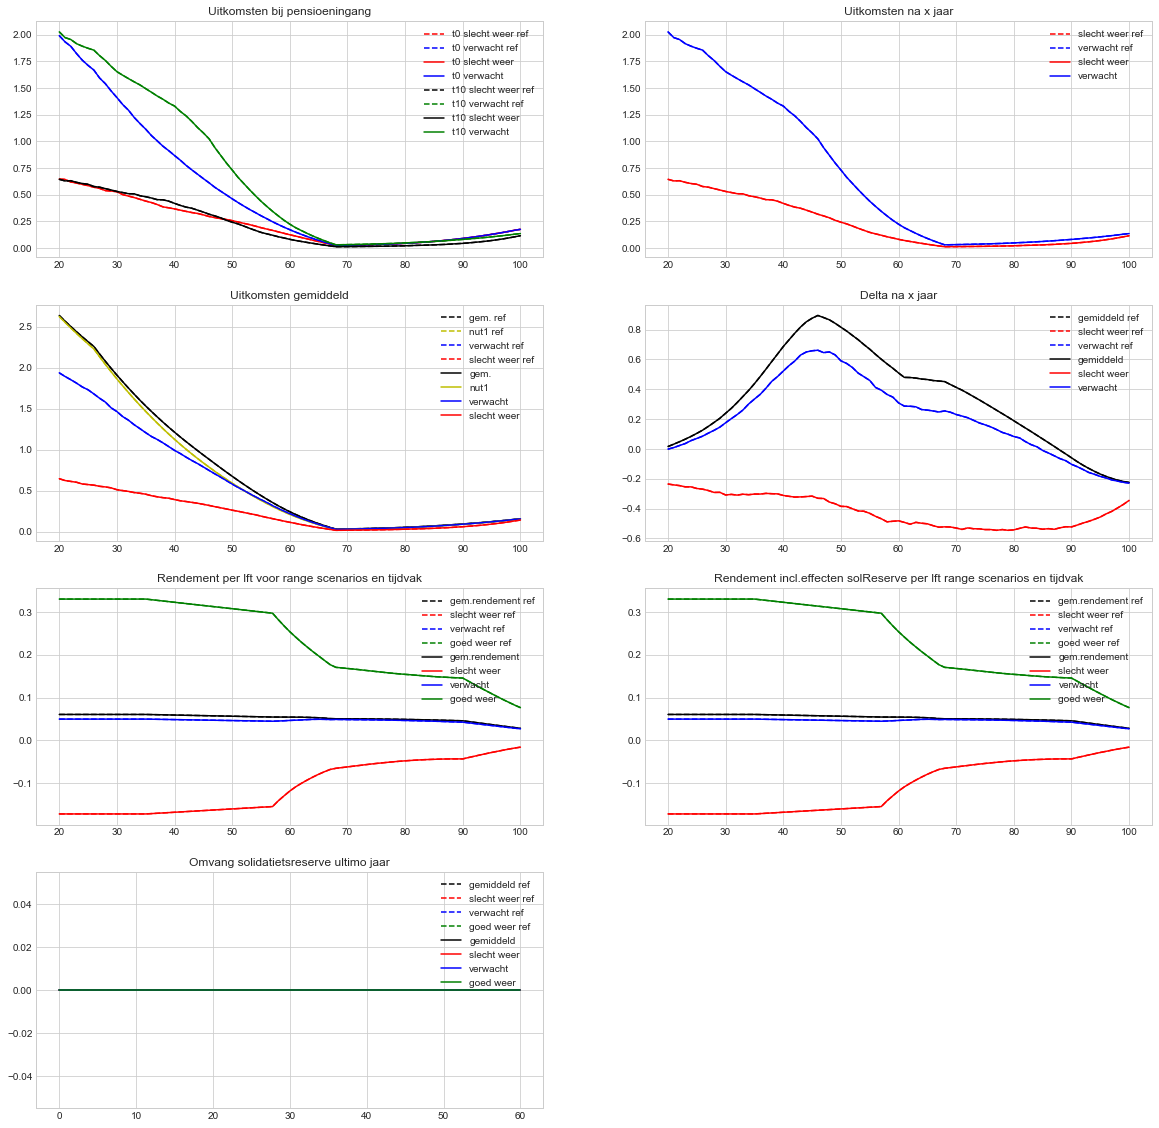


aanpassingen voor een nu  68 -jarige deelnemer



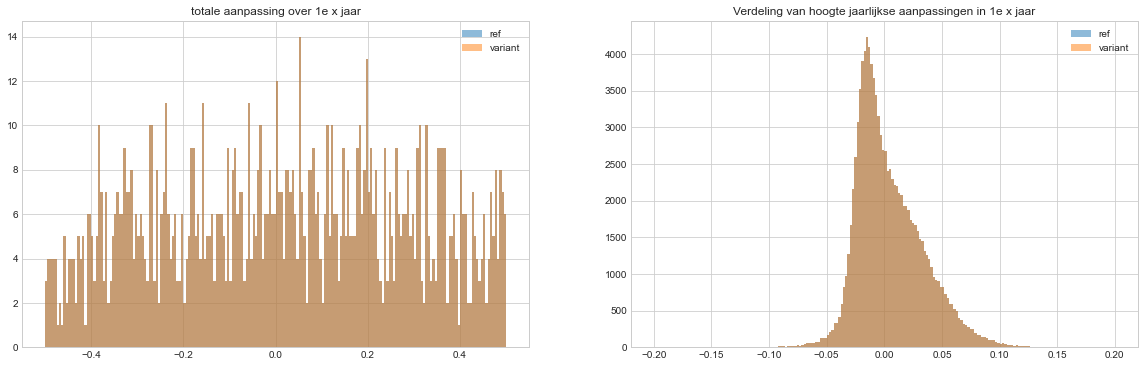

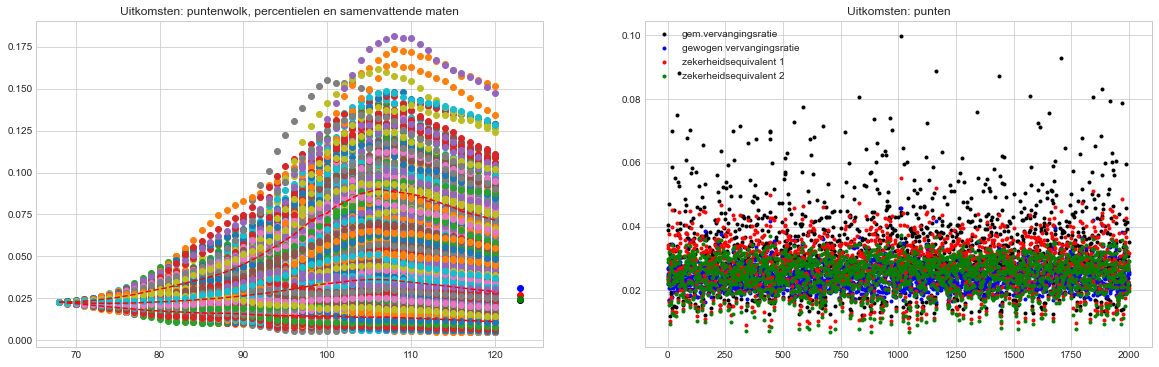



aanpassingen voor een nu  68 -jarige deelnemer scenarios:  1  t/m  1999 Tijdvak:  1 t/m  60

INZICHTEN SOLIDARITEITSRESERVE PORTEFEUILLENIVEAU:

Puur rendement:  5.030274303358813   [-6.55096216  4.87336257 17.04687246]
na sol rendement:  5.030274303358814   [-6.55096216  4.87336257 17.04687246]
In solRes overR:  4.968943731591586e-16   [-4.35458961e-14  0.00000000e+00  4.44089210e-14]
Uit solRes overR:  0.0   [0. 0. 0.]
In solRes Premie:  0.0   [-0. -0. -0.]
Uit solRes VPV:  0.0   [0. 0. 0.]




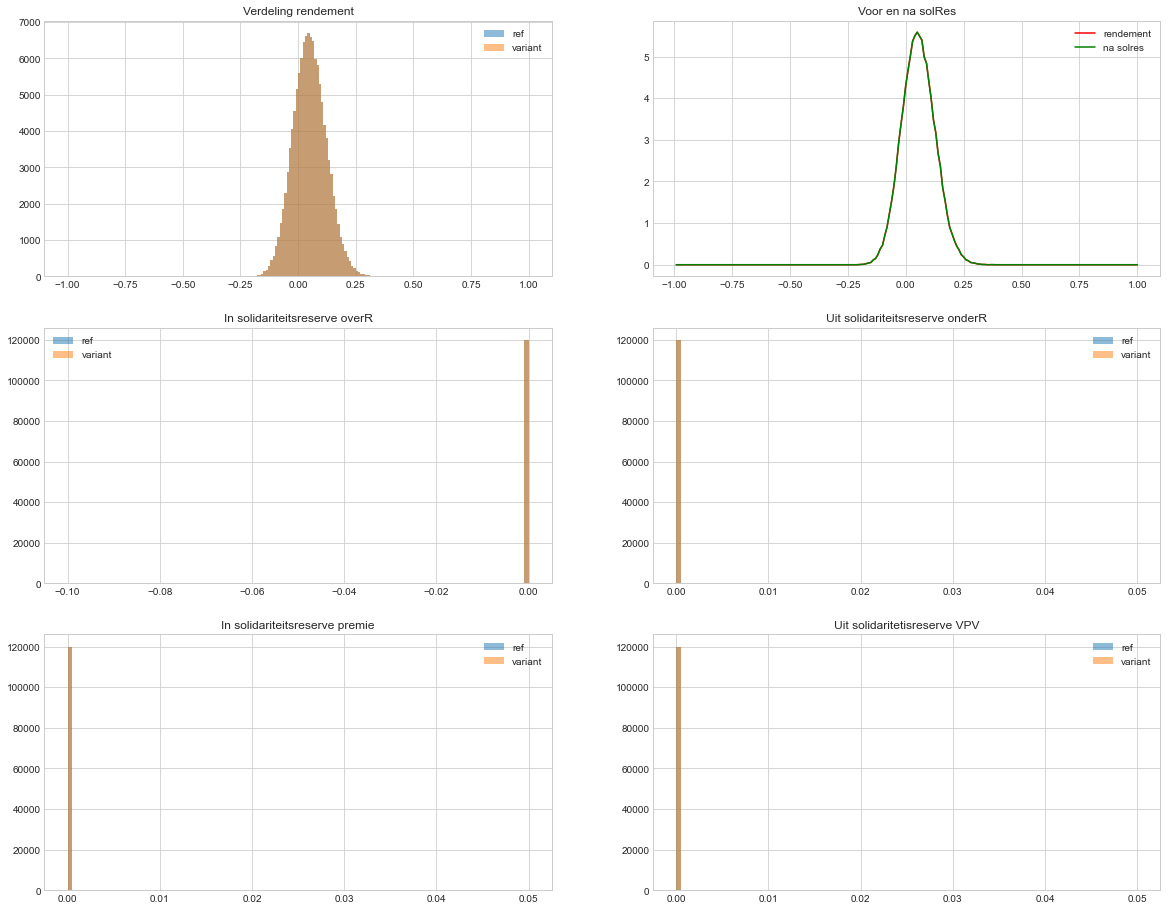

In [14]:
%matplotlib inline

#inlezen sliders keuze en aanmaken ranges om te tonen
slRangeSc.max=aantalScenarios
slIndivSc.max=aantalScenarios
display(HBox([slRangeSc, slLft,slRangeTijd,chVanafPlft],style=style))
display(HBox([chAOW,chKoopK,chVervRatio,chVervRatioML],style=style))
display(HBox([slPerc1, slPerc2,slPerc3],style=style))
display(HBox([slGamma1, slGamma2],style=style))

indivSc=slIndivSc.value

startTijd=slRangeTijd.value[0]-1
eindTijd=slRangeTijd.value[1]-1
bL=slLft.value #startleeftijd dln
bSc=slRangeSc.value[0]-1 #indices beginnen met 0
eSc=slRangeSc.value[1]-1 #indices beginnen met 0

aj=eindTijd-startTijd+1 #aantal jaar progn
bj=startTijd #begin jaar uitkeringen an bJ jaar mee
if chVanafPlft.value:
    bj=max(0,vanafLeeftijd+bj-bL)
aj=min(aj,fixGrens-bL-bj) #reeks aantal jaar afkappen op einde (120 laatste waarde)
aj=min(aj,aantalJaar-bj)

# voor individuele deelnemer in range scenarios en tijdvak (tijdvak al dan niet vanaf plft)
x=range(bL+bj,bL+bj+aj)
points=recht[bj:bj+aj,bL,bSc:eSc+1]
rpoints=rrecht[bj:bj+aj,bL,bSc:eSc+1]
if chAOW.value:
    points=points+aow[bj:bj+aj,bL,bSc:eSc+1]
    rpoints=rpoints+raow[bj:bj+aj,bL,bSc:eSc+1]
if chVervRatio.value and chVervRatioML.value==False:
    points=points/salaris[bj:bj+aj,bL,bSc:eSc+1]
    rpoints=rpoints/rsalaris[bj:bj+aj,bL,bSc:eSc+1]    
if chVervRatioML.value:
    points=points/gsD[bj:bj+aj,bL,bSc:eSc+1]
    rpoints=rpoints/rgsD[bj:bj+aj,bL,bSc:eSc+1]         
if chKoopK.value:
    points=points*kk[bj:bj+aj,bL,bSc:eSc+1]
    rpoints=rpoints*rkk[bj:bj+aj,bL,bSc:eSc+1]
    
weging=nPx2[bL+bj,max(0,vanafLeeftijd-bL)][:aj]    
somWegingsFactoren=np.sum(weging)
gewogenPoints=points*weging[:,np.newaxis]
rweging=rnPx2[bL+bj,max(0,vanafLeeftijd-bL)][:aj]    
rsomWegingsFactoren=np.sum(rweging)
rgewogenPoints=rpoints*rweging[:,np.newaxis]

gemVRPerSc=np.mean(points,axis=0)
gemVRgewogenPerSc=np.sum(gewogenPoints,axis=0)/somWegingsFactoren
nut1PerSc=utilOngewogen2(points,slGamma1.value,axis=0)
nut2PerSc=utilOngewogen2(points,slGamma2.value,axis=0)
nut1PerScgew=utilOngewogen2(gewogenPoints,slGamma1.value,axis=0)
nut2PerScgew=utilOngewogen2(gewogenPoints,slGamma2.value,axis=0)
perc=np.percentile(points,[slPerc1.value,slPerc2.value,slPerc3.value],axis=1)
percGewogen=np.percentile(gemVRgewogenPerSc,[slPerc1.value,slPerc2.value,slPerc3.value])
gemVR=np.mean(gemVRPerSc)
gemVRgewogen=np.mean(gemVRgewogenPerSc)
nut1=np.mean(nut1PerSc)
nut2=np.mean(nut2PerSc)
nut1gew=np.mean(nut1PerScgew)
nut2gew=np.mean(nut2PerScgew)

rgemVRPerSc=np.mean(rpoints,axis=0)
rgemVRgewogenPerSc=np.sum(rgewogenPoints,axis=0)/rsomWegingsFactoren
rnut1PerSc=utilOngewogen2(rpoints,slGamma1.value,axis=0)
rnut2PerSc=utilOngewogen2(rpoints,slGamma2.value,axis=0)
rnut1PerScgew=utilOngewogen2(rgewogenPoints,slGamma1.value,axis=0)
rnut2PerScgew=utilOngewogen2(rgewogenPoints,slGamma2.value,axis=0)
rperc=np.percentile(rpoints,[slPerc1.value,slPerc2.value,slPerc3.value],axis=1)
rpercGewogen=np.percentile(rgemVRgewogenPerSc,[slPerc1.value,slPerc2.value,slPerc3.value])
rgemVR=np.mean(rgemVRPerSc)
rgemVRgewogen=np.mean(rgemVRgewogenPerSc)
rnut1=np.mean(rnut1PerSc)
rnut2=np.mean(rnut2PerSc)
rnut1gew=np.mean(rnut1PerScgew)
rnut2gew=np.mean(rnut2PerScgew)


# DIT NOG AANPASSEN AAN TIJDVAKKKEN

# bereken uitkomsten voor alle leeftijden gem en percentielen. gem, percentielen, nut 1 en nut2
punten=recht[:,:,bSc:eSc+1]
rpunten=rrecht[:,:,bSc:eSc+1]
if chAOW.value:
    punten=punten+aow[:,:,bSc:eSc+1]
    rpunten=rpunten+raow[:,:,bSc:eSc+1]  
if chVervRatio.value and chVervRatioML.value==False:
    punten=np.divide(punten,salaris[:,:,bSc:eSc+1],out=np.zeros_like(punten), where=salaris[:,:,bSc:eSc+1]!=0)
    rpunten=np.divide(rpunten,rsalaris[:,:,bSc:eSc+1],out=np.zeros_like(rpunten), where=rsalaris[:,:,bSc:eSc+1]!=0)    
if chVervRatioML.value:
    punten=np.divide(punten,gsD[:,:,bSc:eSc+1],out=np.zeros_like(punten), where=gsD[:,:,bSc:eSc+1]!=0)
    rpunten=np.divide(rpunten,rgsD[:,:,bSc:eSc+1],out=np.zeros_like(rpunten), where=rgsD[:,:,bSc:eSc+1]!=0)    
if chKoopK.value:
    punten=punten*kk[:,:,bSc:eSc+1]    
    rpunten=rpunten*rkk[:,:,bSc:eSc+1]    
    
#bereken uitkomsten per leeftijd  in range scenario en tijdvak
uitkomsten=np.zeros([fixGrens,22])
for lf in np.arange(20,101,1):
    bj2=startTijd #begin jaar uitkeringen an bJ jaar mee
    begin=max(0,vanafLeeftijd+bj2-lf)  
    aj2=eindTijd-startTijd #
    aj2=min(aj2,fixGrens-lf-begin) #reeks aantal jaar afkappen op einde (120 laatste waarde)
    aj2=min(aj2,aantalJaar-begin)

    puntLft=punten[begin:begin+aj2+1,lf,:]    
    #aanvang
    aanvang=np.mean(puntLft[0,:],axis=0)  
    #na 10 jaar
    na10Jaar=np.mean(puntLft[aj2,:],axis=0)
    #delta10
    delta10=puntLft[aj2,:]/puntLft[0,:]-1.0    
    #gem ongewogen
    gemVRPerSc1=np.mean(puntLft,axis=0)
    nut1Sc=np.mean(utilOngewogen2(puntLft,slGamma1.value,axis=0))
    nut2Sc=np.mean(utilOngewogen2(puntLft,slGamma2.value,axis=0))
    #gem gewogen
    weging1=nPx2[lf+begin,max(0,vanafLeeftijd-lf)][:aj2+1]    
    somWegingsFactoren1=np.sum(weging1)
    gewogenPunten1=puntLft*weging1[:,np.newaxis]
    gemVRgewogenPerSc1=np.sum(gewogenPunten1,axis=0)/somWegingsFactoren1
    uitkomsten[lf,0]=aanvang
    uitkomsten[lf,1:4]=np.percentile(puntLft[0,:],[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)    
    uitkomsten[lf,4]=na10Jaar
    uitkomsten[lf,5:8]=np.percentile(puntLft[aj2,:],[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)    
    uitkomsten[lf,8]=np.mean(gemVRPerSc1)
    uitkomsten[lf,9:12]=np.percentile(gemVRPerSc1,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    uitkomsten[lf,12]=nut1Sc
    uitkomsten[lf,13]=nut2Sc
    uitkomsten[lf,14]=np.mean(gemVRPerSc1)
    uitkomsten[lf,15:18]=np.percentile(gemVRgewogenPerSc1,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    uitkomsten[lf,18]=np.mean(delta10)
    uitkomsten[lf,19:22]=np.percentile(delta10,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)    
    if lf==bL:
        uitX=puntLft.copy()
#print(uitkomsten[slLft.value,:])

#bereken uitkomsten per leeftijd referentie

ruitkomsten=np.zeros([fixGrens,22])
for lf in np.arange(20,101,1):
    bj2=startTijd #begin jaar uitkeringen an bJ jaar mee
    begin=max(0,vanafLeeftijd+bj2-lf)  
    aj2=eindTijd-startTijd#
    aj2=min(aj2,fixGrens-lf-begin) #reeks aantal jaar afkappen op einde (120 laatste waarde)
    aj2=min(aj2,aantalJaar-begin)   

    puntLft=rpunten[begin:begin+aj2+1,lf,:]    
    #aanvang
    aanvang=np.mean(puntLft[0,:],axis=0)  
    #na 10 jaar
    na10Jaar=np.mean(puntLft[aj2,:],axis=0)
    #delta10
    delta10=puntLft[aj2,:]/puntLft[0,:]-1.0
    #gem ongewogen
    gemVRPerSc1=np.mean(puntLft,axis=0)
    nut1Sc=np.mean(utilOngewogen2(puntLft,slGamma1.value,axis=0))
    nut2Sc=np.mean(utilOngewogen2(puntLft,slGamma2.value,axis=0))
    #gem gewogen
    weging1=rnPx2[lf+begin,max(0,vanafLeeftijd-lf)][:aj2+1]    
    somWegingsFactoren1=np.sum(weging1)
    gewogenPunten1=puntLft*weging1[:,np.newaxis]
    gemVRgewogenPerSc1=np.sum(gewogenPunten1,axis=0)/somWegingsFactoren1
    ruitkomsten[lf,0]=aanvang
    ruitkomsten[lf,1:4]=np.percentile(puntLft[0,:],[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)    
    ruitkomsten[lf,4]=na10Jaar
    ruitkomsten[lf,5:8]=np.percentile(puntLft[aj2,:],[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)    
    ruitkomsten[lf,8]=np.mean(gemVRPerSc1)
    ruitkomsten[lf,9:12]=np.percentile(gemVRPerSc1,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    ruitkomsten[lf,12]=nut1Sc
    ruitkomsten[lf,13]=nut2Sc
    ruitkomsten[lf,14]=np.mean(gemVRPerSc1)
    ruitkomsten[lf,15:18]=np.percentile(gemVRgewogenPerSc1,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    ruitkomsten[lf,18]=np.mean(delta10)
    ruitkomsten[lf,19:22]=np.percentile(delta10,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)   
    if lf==bL:
        ruitX=puntLft.copy()
#print(ruitkomsten[slLft.value,:])


#bereken rendementen per lft incl en excl effecten solres:  voor range scenarios en tijdvak
rendementenPerLft=np.zeros([fixGrens,8])
for lf in np.arange(20,101,1):
    plft=np.reshape(rendementen[startTijd:eindTijd+1,lf,bSc:eSc+1],rendementen[startTijd:eindTijd+1,lf,bSc:eSc+1].size)
    rendementenPerLft[lf,0]=np.mean(plft)
    rendementenPerLft[lf,1:4]=np.percentile(plft,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    plft2=np.reshape(rendementenNaInSol[startTijd:eindTijd+1,lf,bSc:eSc+1]+rendementenNaUitSol[startTijd:eindTijd+1,lf,bSc:eSc+1]-rendementenInSolPremie[startTijd:eindTijd+1,lf,bSc:eSc+1]+rendementenSolVPV[startTijd:eindTijd+1,lf,bSc:eSc+1],rendementen[startTijd:eindTijd+1,lf,bSc:eSc+1].size)
    rendementenPerLft[lf,4]=np.mean(plft2)
    rendementenPerLft[lf,5:9]=np.percentile(plft2,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

#bereken rendementen per lft incl en excl effecten solres refer
rrendementenPerLft=np.zeros([fixGrens,8])
for lf in np.arange(20,101,1):
    plft=np.reshape(rrendementen[startTijd:eindTijd+1,lf,bSc:eSc+1],rrendementen[startTijd:eindTijd+1,lf,bSc:eSc+1].size)
    rrendementenPerLft[lf,0]=np.mean(plft)
    rrendementenPerLft[lf,1:4]=np.percentile(plft,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    plft2=np.reshape(rrendementenNaInSol[startTijd:eindTijd+1,lf,bSc:eSc+1]+rrendementenNaUitSol[startTijd:eindTijd+1,lf,bSc:eSc+1]-rrendementenInSolPremie[startTijd:eindTijd+1,lf,bSc:eSc+1]+rrendementenSolVPV[startTijd:eindTijd+1,lf,bSc:eSc+1],rrendementen[startTijd:eindTijd+1,lf,bSc:eSc+1].size)
    rrendementenPerLft[lf,4]=np.mean(plft2)
    rrendementenPerLft[lf,5:9]=np.percentile(plft2,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
    
print()
print()
print("vervanginsgratios    gemiddeld: ",gemVR," in percentielen: ",np.mean(perc,axis=1))
print("vervanginsgratios    gewogen  : ",gemVRgewogen," in percentielen: ",percGewogen)
print("ze kerheidsequialenten        1: ",nut1," 2: ",nut2," gewogen 1: ",nut1gew," gewogen 2: ",nut2gew)
print()

#grafieken vergelijk a met ref

asXl=np.arange(20,101)
plt.rcParams['figure.figsize'] = [20, 20]
plt.style.use('seaborn-whitegrid')
plt.tight_layout()

plt.subplot(4,2,1)
plt.title("Uitkomsten bij pensioeningang") 
#plt.ylim([0.2, 2])
asXl=np.arange(20,101)
plt.plot(asXl,ruitkomsten[20:101,1], '--r', label='t0 slecht weer ref',markersize=1)
plt.plot(asXl,ruitkomsten[20:101,2], '--b', label='t0 verwacht ref ',markersize=1)
plt.plot(asXl,uitkomsten[20:101,1], '-r', label='t0 slecht weer',markersize=3)
plt.plot(asXl,uitkomsten[20:101,2], '-b', label='t0 verwacht',markersize=3)
plt.plot(asXl,ruitkomsten[20:101,5], '--k', label='t10 slecht weer ref',markersize=1)
plt.plot(asXl,ruitkomsten[20:101,6], '--g', label='t10 verwacht ref ',markersize=1)
plt.plot(asXl,uitkomsten[20:101,5], '-k', label='t10 slecht weer',markersize=3)
plt.plot(asXl,uitkomsten[20:101,6], '-g', label='t10 verwacht',markersize=3)
leg = plt.legend();

plt.subplot(4,2,2)
plt.title("Uitkomsten na x jaar") 
asX2=np.arange(20,101)
plt.plot(asX2,ruitkomsten[20:101,5], '--r', label='slecht weer ref',markersize=3)
plt.plot(asX2,ruitkomsten[20:101,6], '--b', label='verwacht ref ',markersize=3)
plt.plot(asX2,uitkomsten[20:101,5], '-r', label='slecht weer',markersize=3)
plt.plot(asX2,uitkomsten[20:101,6], '-b', label='verwacht',markersize=3)
leg = plt.legend();

plt.subplot(4,2,3)
plt.title("Uitkomsten gemiddeld")
asX3=np.arange(20,101)
plt.plot(asX3,ruitkomsten[20:101,8], '--k', label='gem. ref',markersize=3)
plt.plot(asX3,ruitkomsten[20:101,12], '--y', label='nut1 ref',markersize=3)
plt.plot(asX3,ruitkomsten[20:101,10], '--b', label='verwacht ref ',markersize=3)
plt.plot(asX3,ruitkomsten[20:101,9], '--r', label='slecht weer ref',markersize=3)

plt.plot(asX3,uitkomsten[20:101,8], '-k', label='gem.',markersize=3)
plt.plot(asX3,uitkomsten[20:101,12], '-y', label='nut1',markersize=3)
plt.plot(asX3,uitkomsten[20:101,10], '-b', label='verwacht',markersize=3)
plt.plot(asX3,uitkomsten[20:101,9], '-r', label='slecht weer',markersize=3)
leg = plt.legend();


# HIER BORGEN ALTIJD VANAF PLFT
plt.subplot(4,2,4)  
plt.title("Delta na x jaar") 
asX4=np.arange(20,101)
plt.plot(asX4,ruitkomsten[20:101,18], '--k', label='gemiddeld ref',markersize=3)
plt.plot(asX4,ruitkomsten[20:101,19], '--r', label='slecht weer ref',markersize=3)
plt.plot(asX4,ruitkomsten[20:101,20], '--b', label='verwacht ref ',markersize=3)
plt.plot(asX4,uitkomsten[20:101,18], '-k', label='gemiddeld',markersize=3)
plt.plot(asX4,uitkomsten[20:101,19], '-r', label='slecht weer',markersize=3)
plt.plot(asX4,uitkomsten[20:101,20], '-b', label='verwacht',markersize=3)
leg = plt.legend();

plt.subplot(4,2,5)
plt.title("Rendement per lft voor range scenarios en tijdvak") 
xAs=np.arange(20,101)
plt.plot(xAs,rrendementenPerLft[20:101,0] , '--k', label='gem.rendement ref',markersize=3)
plt.plot(xAs,rrendementenPerLft[20:101,1] , '--r', label='slecht weer ref',markersize=3)
plt.plot(xAs,rrendementenPerLft[20:101,2] , '--b', label='verwacht ref',markersize=3)
plt.plot(xAs,rrendementenPerLft[20:101,3] , '--g', label='goed weer ref',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,0] , '-k', label='gem.rendement',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,1] , '-r', label='slecht weer',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,2] , '-b', label='verwacht',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,3] , '-g', label='goed weer',markersize=3)
leg = plt.legend();

plt.subplot(4,2,6)
plt.title("Rendement incl.effecten solReserve per lft range scenarios en tijdvak") 
xAs=np.arange(20,101)
plt.plot(xAs,rrendementenPerLft[20:101,4] , '--k', label='gem.rendement ref',markersize=3)
plt.plot(xAs,rrendementenPerLft[20:101,5] , '--r', label='slecht weer ref',markersize=3)
plt.plot(xAs,rrendementenPerLft[20:101,6] , '--b', label='verwacht ref',markersize=3)
plt.plot(xAs,rrendementenPerLft[20:101,7] , '--g', label='goed weer ref',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,4] , '-k', label='gem.rendement',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,5] , '-r', label='slecht weer',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,6] , '-b', label='verwacht',markersize=3)
plt.plot(xAs,rendementenPerLft[20:101,7] , '-g', label='goed weer',markersize=3)
leg = plt.legend();

plt.subplot(4,2,7)
plt.title("Omvang solidatietsreserve ultimo jaar") 
percSolRes=np.percentile(omvangSolRes[:,bSc:eSc+1],[slPerc1.value,slPerc2.value,slPerc3.value],axis=1)
rpercSolRes=np.percentile(romvangSolRes[:,bSc:eSc+1],[slPerc1.value,slPerc2.value,slPerc3.value],axis=1)
asX=np.arange(aantalJaar+1)
plt.plot(asX,np.mean(romvangSolRes[:,bSc:eSc+1],axis=1) , '--k', label='gemiddeld ref',markersize=3)
plt.plot(asX,rpercSolRes[0], '--r', label='slecht weer ref',markersize=3)
plt.plot(asX,rpercSolRes[1], '--b', label='verwacht ref',markersize=3)
plt.plot(asX,rpercSolRes[2], '--g', label='goed weer ref',markersize=3)
plt.plot(asX,np.mean(omvangSolRes[:,bSc:eSc+1],axis=1) , '-k', label='gemiddeld',markersize=3)
plt.plot(asX,percSolRes[0], '-r', label='slecht weer',markersize=3)
plt.plot(asX,percSolRes[1], '-b', label='verwacht',markersize=3)
plt.plot(asX,percSolRes[2], '-g', label='goed weer',markersize=3)
leg = plt.legend();

plt.show()

# grafieken uitkomsten, puntenwolk, aanpassing en rendement-------------------------
print()
print("aanpassingen voor een nu ",bL,"-jarige deelnemer")
print()

plt.rcParams['figure.figsize'] = [20, 6]
plt.style.use('seaborn-whitegrid')
plt.tight_layout()

plt.subplot(1,2,1)
plt.title("totale aanpassing over 1e x jaar")
bn2=np.linspace(-0.5,0.5,num=201)
aanpassingen=np.divide(uitX[-1,:],uitX[0,:],out=np.ones_like(uitX[-1,:]), where=uitX[0,:]!=0)-1.0
raanpassingen=np.divide(ruitX[-1,:],ruitX[0,:],out=np.ones_like(ruitX[-1,:]), where=ruitX[0,:]!=0)-1.0
plt.hist(raanpassingen, bins =bn2,alpha=0.5,label='ref') 
plt.hist(aanpassingen, bins =bn2,alpha=0.5,label='variant') 
leg = plt.legend();

plt.subplot(1,2,2)
plt.title("Verdeling van hoogte jaarlijkse aanpassingen in 1e x jaar") 
bn2=np.linspace(-0.2,0.2,num=201)
aanpassingen=np.divide(uitX[1:,:],uitX[:-1,:],out=np.ones_like(uitX[1:,:]), where=uitX[:-1,:]!=0)-1.0
raanpassingen=np.divide(ruitX[1:,:],ruitX[:-1,:],out=np.ones_like(ruitX[1:,:]), where=ruitX[:-1,:]!=0)-1.0
aanpassingenAllen=np.reshape(aanpassingen, aanpassingen.size)
raanpassingenAllen=np.reshape(raanpassingen, raanpassingen.size)
plt.hist(raanpassingenAllen, bins =bn2,alpha=0.5,label='ref') 
plt.hist(aanpassingenAllen, bins =bn2,alpha=0.5,label='variant') 
leg = plt.legend();

plt.show()


# grafieken uitkomsten, puntenwolk, aanpassing en rendement- individuele deelnemer in range scenarios en tijdvak------------------------
xShow=range(bL+bj,bL+bj+aj)
plt.rcParams['figure.figsize'] = [20, 6]
plt.style.use('seaborn-whitegrid')
plt.tight_layout()

plt.subplot(1,2,1)
plt.title("Uitkomsten: puntenwolk, percentielen en samenvattende maten") 
plt.plot(xShow, points,'o',xShow,perc.transpose(),'r--',bL+bj+aj+2,gemVR,'bo',bL+bj+aj+2,gemVRgewogen,'ko',bL+bj+aj+2,nut1,'ro',bL+bj+aj+2,nut2,'go'); # Plot some data on the axes.

plt.subplot(1,2,2)
plt.title("Uitkomsten: punten") 
xShow2=np.arange(bSc,eSc+1)
plt.plot(xShow2,gemVRPerSc , 'ok', label='gem.vervangingsratie',markersize=3)
plt.plot(xShow2,gemVRgewogenPerSc , 'ob', label='gewogen vervangingsratie',markersize=3)
plt.plot(xShow2,nut1PerSc , 'or', label='zekerheidsequivalent 1',markersize=3)
plt.plot(xShow2,nut2PerSc , 'og', label='zekerheidsequivalent 2',markersize=3)
leg = plt.legend();
plt.show()



# bereken effecten solidaritetsreserve inzicht voor indiv deelnemer met specifieke leeftijd. voor range van scenario's en tijdsvak uit tijdrange
re=np.reshape(rendementen[startTijd:eindTijd+1,bL,bSc:eSc+1], rendementen[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
reGem=np.mean(re)
rePerc=np.percentile(re,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
rre=np.reshape(rrendementen[startTijd:eindTijd+1,bL,bSc:eSc+1], rrendementen[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
rreGem=np.mean(rre)
rrePerc=np.percentile(rre,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

re2=np.reshape(rendementenNaInSol[startTijd:eindTijd+1,bL,bSc:eSc+1], rendementenNaInSol[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
re2Gem=np.mean(re2)
re2Perc=np.percentile(re2,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
rre2=np.reshape(rrendementenNaInSol[startTijd:eindTijd+1,bL,bSc:eSc+1], rrendementenNaInSol[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
rre2Gem=np.mean(rre2)
rre2Perc=np.percentile(rre2,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

reD=re2-re
reDGem=np.mean(reD)
reDPerc=np.percentile(reD,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
rreD=rre2-rre
rreDGem=np.mean(rreD)
rreDPerc=np.percentile(rreD,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

reU=np.reshape(rendementenNaUitSol[startTijd:eindTijd+1,bL,bSc:eSc+1], rendementenNaUitSol[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
reUGem=np.mean(reU)
reUPerc=np.percentile(reU,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
rreU=np.reshape(rrendementenNaUitSol[startTijd:eindTijd+1,bL,bSc:eSc+1], rrendementenNaUitSol[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
rreUGem=np.mean(rreU)
rreUPerc=np.percentile(rreU,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

reP=np.reshape(-rendementenInSolPremie[startTijd:eindTijd+1,bL,bSc:eSc+1], rendementenInSolPremie[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
rePGem=np.mean(reP)
rePPerc=np.percentile(reP,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
rreP=np.reshape(-rrendementenInSolPremie[startTijd:eindTijd+1,bL,bSc:eSc+1], rrendementenInSolPremie[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
rrePGem=np.mean(rreP)
rrePPerc=np.percentile(rreP,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

reV=np.reshape(rendementenSolVPV[startTijd:eindTijd+1,bL,bSc:eSc+1], rendementenSolVPV[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
reVGem=np.mean(reV)
reVPerc=np.percentile(reV,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)
rreV=np.reshape(rrendementenSolVPV[startTijd:eindTijd+1,bL,bSc:eSc+1], rrendementenSolVPV[startTijd:eindTijd+1,bL,bSc:eSc+1].size)
rreVGem=np.mean(rreV)
rreVPerc=np.percentile(rreV,[slPerc1.value,slPerc2.value,slPerc3.value],axis=0)

bn=np.linspace(-1,1,num=201)
kans1,grens1=np.histogram(re,bins=bn,density=True)
kans2,grens2=np.histogram(re2+reU,bins=bn,density=True)
rkans1,grens1=np.histogram(rre,bins=bn,density=True)
rkans2,grens2=np.histogram(rre2+reU,bins=bn,density=True)

bn2=np.linspace(-0.1,0.0,num=101)
bn3=np.linspace(0.0,0.05,num=101)

print()
print()
print("aanpassingen voor een nu ",bL,"-jarige deelnemer", "scenarios: ",bSc+1," t/m ",eSc,"Tijdvak: ",startTijd+1 ,"t/m ",eindTijd+1)
print()
print("INZICHTEN SOLIDARITEITSRESERVE PORTEFEUILLENIVEAU:")
print()
print("Puur rendement: ", reGem*100," ",100*rePerc)
print("na sol rendement: ", re2Gem*100," ",100*re2Perc)
print("In solRes overR: ", reDGem*100," ",100*reDPerc)
print("Uit solRes overR: ", reUGem*100," ",100*reUPerc)      
print("In solRes Premie: ", rePGem*100," ",100*rePPerc)
print("Uit solRes VPV: ", reVGem*100," ",100*reVPerc)  

print()
print()


plt.rcParams['figure.figsize'] = [20, 16]
plt.style.use('seaborn-whitegrid')
plt.tight_layout()

plt.subplot(3,2,1)
plt.title("Verdeling rendement") 
plt.hist(rre, bins = bn,alpha=0.5,label="ref")
plt.hist(re, bins = bn,alpha=0.5,label="variant")
leg = plt.legend();
plt.subplot(3,2,2)
plt.title("Voor en na solRes") 
#plt.plot(grens1[1:],rkans1 , '--r', label='rendement ref')
#plt.plot(grens1[1:],rkans2 , '--g', label='na solres ref')
plt.plot(grens1[1:],kans1 , '-r', label='rendement')
plt.plot(grens1[1:],kans2 , '-g', label='na solres')
leg = plt.legend();
plt.subplot(3,2,3)

plt.title("In solidariteitsreserve overR") 
bn4=np.linspace(-0.1,0.000001,num=101)
plt.hist(rreD, bins =bn4,alpha=0.5,label="ref")
plt.hist(reD, bins =bn4,alpha=0.5,label="variant")
leg = plt.legend();

plt.subplot(3,2,4)
plt.title("Uit solidariteitsreserve onderR") 
plt.hist(rreU, bins = bn3,alpha=0.5,label="ref")
plt.hist(reU, bins = bn3,alpha=0.5,label="variant") 
leg = plt.legend();

plt.subplot(3,2,5)
plt.title("In solidariteitsreserve premie") 
plt.hist(rreP, bins = bn3,alpha=0.5,label="ref")
plt.hist(reP, bins = bn3,alpha=0.5,label="variant") 
leg = plt.legend();
         
plt.subplot(3,2,6)
plt.title("Uit solidaritetisreserve VPV") 
plt.hist(rreV, bins = bn3,alpha=0.5,label="ref")
plt.hist(reV, bins = bn3,alpha=0.5,label="variant") 
leg = plt.legend();
plt.show()

In [15]:
# aantalScenarios=slAantSc.value
# aantalJaar=slAantJr.value
# cw,bes=matchEnCW(aantalScenarios=aantalScenarios,aantJaren=aantalJaar,isVastBeschermRendement=isVastBeschermRendement,vastBeschermRendement=vastBeschermRendement,opslagBeschermRendement=opslagBeschermRendement,isBeschermReeel=isBeschermReeel,isVastProjectieRendement=isVastProjectieRendement,vastProjectieRendement=vastProjectieRendement,opslagProjectieRendement=opslagProjectieRendement,isProjectieReeel=isProjectieReeel)
# print(cw.shape,bes.shape)
# print(bes[0,68,:])